# Applications of different parts of an ROC curve

## Libraries

In [1]:
from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd

In [2]:
mpl.rcParams['figure.dpi'] = 240
mpl.rcParams["figure.facecolor"] = 'white'
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)

## Functions

In [3]:
# Taken from: https://github.com/Big-Life-Lab/partial-AUC-C/blob/main/Python3.7/do_pAUCc.py

def concordant_partial_AUC(pfpr, ptpr):
    ''' Computes the concordant partial area under the curve and alternatives, given arrays of \n
    "partial fpr" and "partial tpr" values.  These arrays only contain points on the partial curve \n
    and the trapezoidal rule is used to compute areas with these points. \n
    \n
    pAUCc:      the concordant partial area under the curve \n
    pAUC:       the (vertical) partial area under the curve \n
    pAUCx:      the horizontal partial area under the curve \n
    pAUCc_norm: the concordant partial area under the curve normalized \n
    pAUC_norm:  the (vertical) partial area under the curve normalized \n
    pAUCx_norm: the horizontal partial area under the curve normalized \n
    '''

    # xrange [a,b]
    a    = float(pfpr[0])
    b    = float(pfpr[-1])
    delx = b - a
    vertical_stripe_area = (1 * delx)

    # yrange [f,g]
    f    = float(ptpr[0])
    g    = float(ptpr[-1])
    dely = g - f
    horizontal_stripe_area = (dely * 1)

    if delx == 0:
        print("Warning: For pAUC and pAUCc the width (delx) of the vertical column is zero.")
        pAUC  = 0
        pAUCn = 0
        sPA   = 0
    else:
        # Compute the partial AUC mathematically defined in (Dodd and Pepe, 2003) and conceptually defined in
        #   (McClish, 1989; Thompson and Zucchini, 1989). Use the trapezoidal rule to compute the integral.
        pAUC  = np.trapz(ptpr, pfpr)  # trapz is y,x
        pAUCn = pAUC / vertical_stripe_area
    #endif

    if dely == 0:
        print("Warning: For pAUCx and pAUCc the height (dely) of the horizontal stripe is zero.")
        pAUCx  = 0
        pAUCxn = 0
    else:
        # Compute the horizontal partial AUC (pAUCx) defined in (Carrington et al, 2020) and as
        # suggested by (Walter, 2005) and similar to the partial area index (PAI)
        # (Nishikawa et al, ?) although PAI has a fixed right boundary instead and a slightly
        # different mathematical definition.
        #
        # Normally we would compute the area to the right of the curve, the horizontal integral,
        # as follows:
        #   1. swap the axes
        #   2. flip the direction of the new vertical
        #   3. compute the (vertical) integral
        #
        tempX  = ptpr                      # swap the axes
        tempY  = list(1 - np.array(pfpr))  # flip the direction
        pAUCx  = np.trapz(tempY, tempX)    # trapz is y,x
        pAUCxn = pAUCx / horizontal_stripe_area
    #endif

    total_for_norm = vertical_stripe_area + horizontal_stripe_area
    if total_for_norm == 0:
        pAUCc  = 0
        pAUCcn = 0
        print('Warning: Zero length partial curve specified.')
    else:
        pAUCc  = (1/2)*pAUCx + (1/2)*pAUC  # the complexity is in the derivation, meaning/generalization
        #   and relation to the c and partial c statistic, not the
        #   formula which looks like a simple average
        #pAUCcn= (pAUCx + pAUC) / total_for_norm
        if vertical_stripe_area > 0 and horizontal_stripe_area > 0: # NEW part-wise normalization
            pAUCcn = (1 / 2) * (pAUC  / vertical_stripe_area) + (1 / 2) * (pAUCx / horizontal_stripe_area)
        elif pAUCn == 1:
            pAUCcn = 1 # best case scenario
        elif vertical_stripe_area   == 0:
            pAUCcn = (1 / 2) * (pAUCx / horizontal_stripe_area)
        elif horizontal_stripe_area == 0:
            pAUCcn = (1 / 2) * (pAUC  / vertical_stripe_area)
        # endif
    #endif
    
    sPA = 0.5*(1+ (pAUC - (pfpr[-1]**2)/2)/ (pfpr[-1] - (pfpr[-1]**2)/2))  # One the use of partial AUC. Hua Ma et all
    
    return pAUCc, pAUC, pAUCx, pAUCcn, pAUCn, pAUCxn, sPA

## Data

In [317]:
data = load_breast_cancer()

In [318]:
data.target.shape

(569,)

In [319]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [320]:
X_train, y_train = data.data[:50], data.target[:50]
X_test, y_test = data.data[50:], data.target[50:]

In [321]:
model= LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [322]:
y_hat = model.predict_proba(X_test)[:,1]

In [323]:
roc_auc_score(y_test, y_hat)

0.9692645815722739

## ROC Curve

In [324]:
fpr, tpr, thres = roc_curve(y_test, y_hat)

Text(0.5, 1.0, 'ROC Curve. AUC: 0.969')

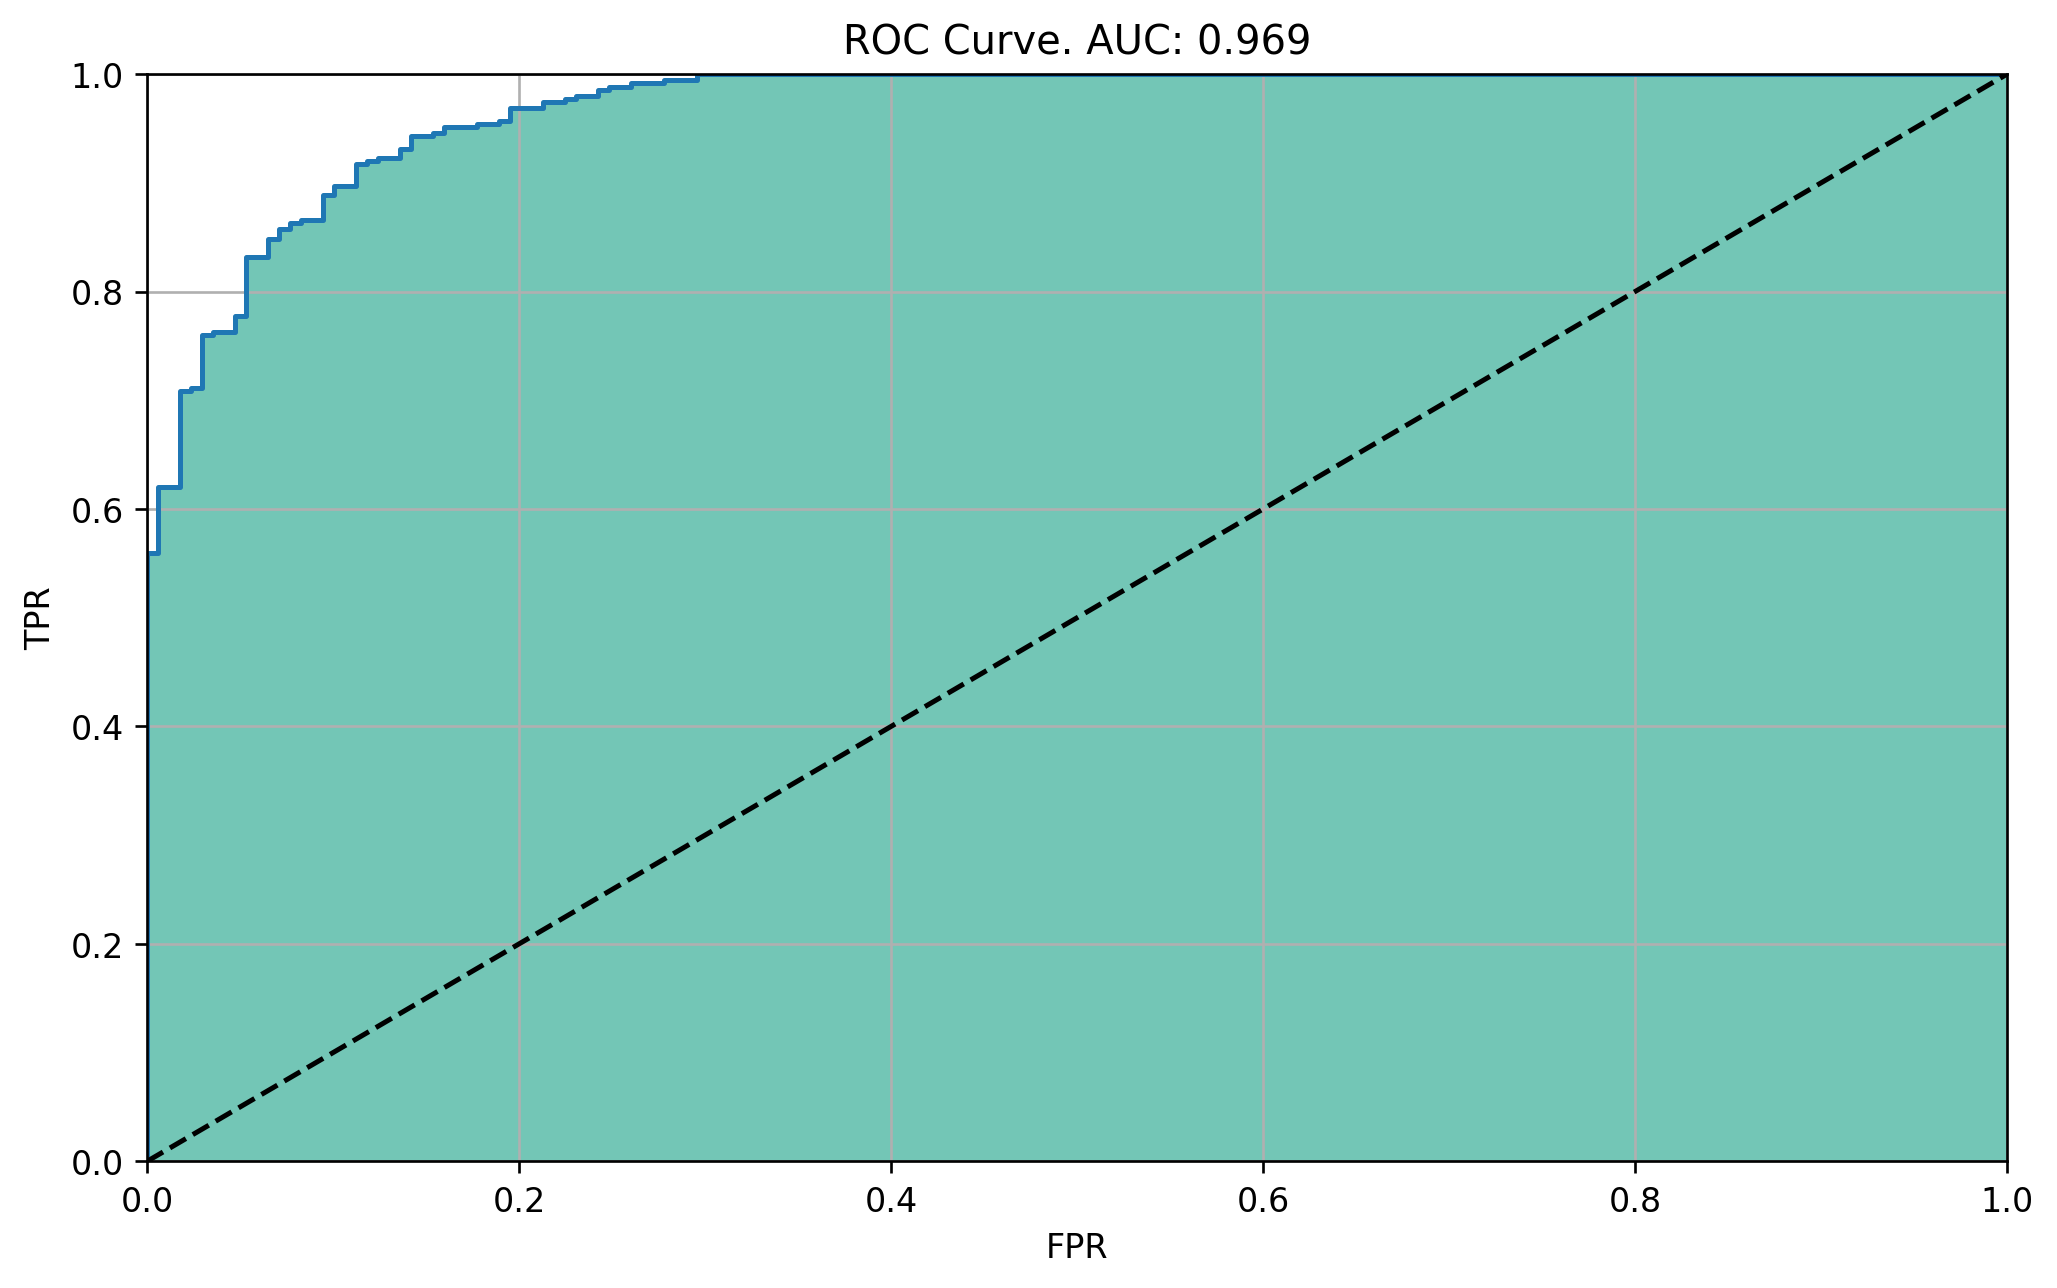

In [325]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], linestyle='--', color='k')
ax.fill_between(fpr, tpr, color='#73C6B6')

ax.grid()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title(f'ROC Curve. AUC: {metrics.auc(fpr, tpr):0.3f}')

## Parts of ROC curve

In [326]:
fpr_cutoff = 0.1
idx = np.where(fpr>fpr_cutoff)[0].min()
idx+=1

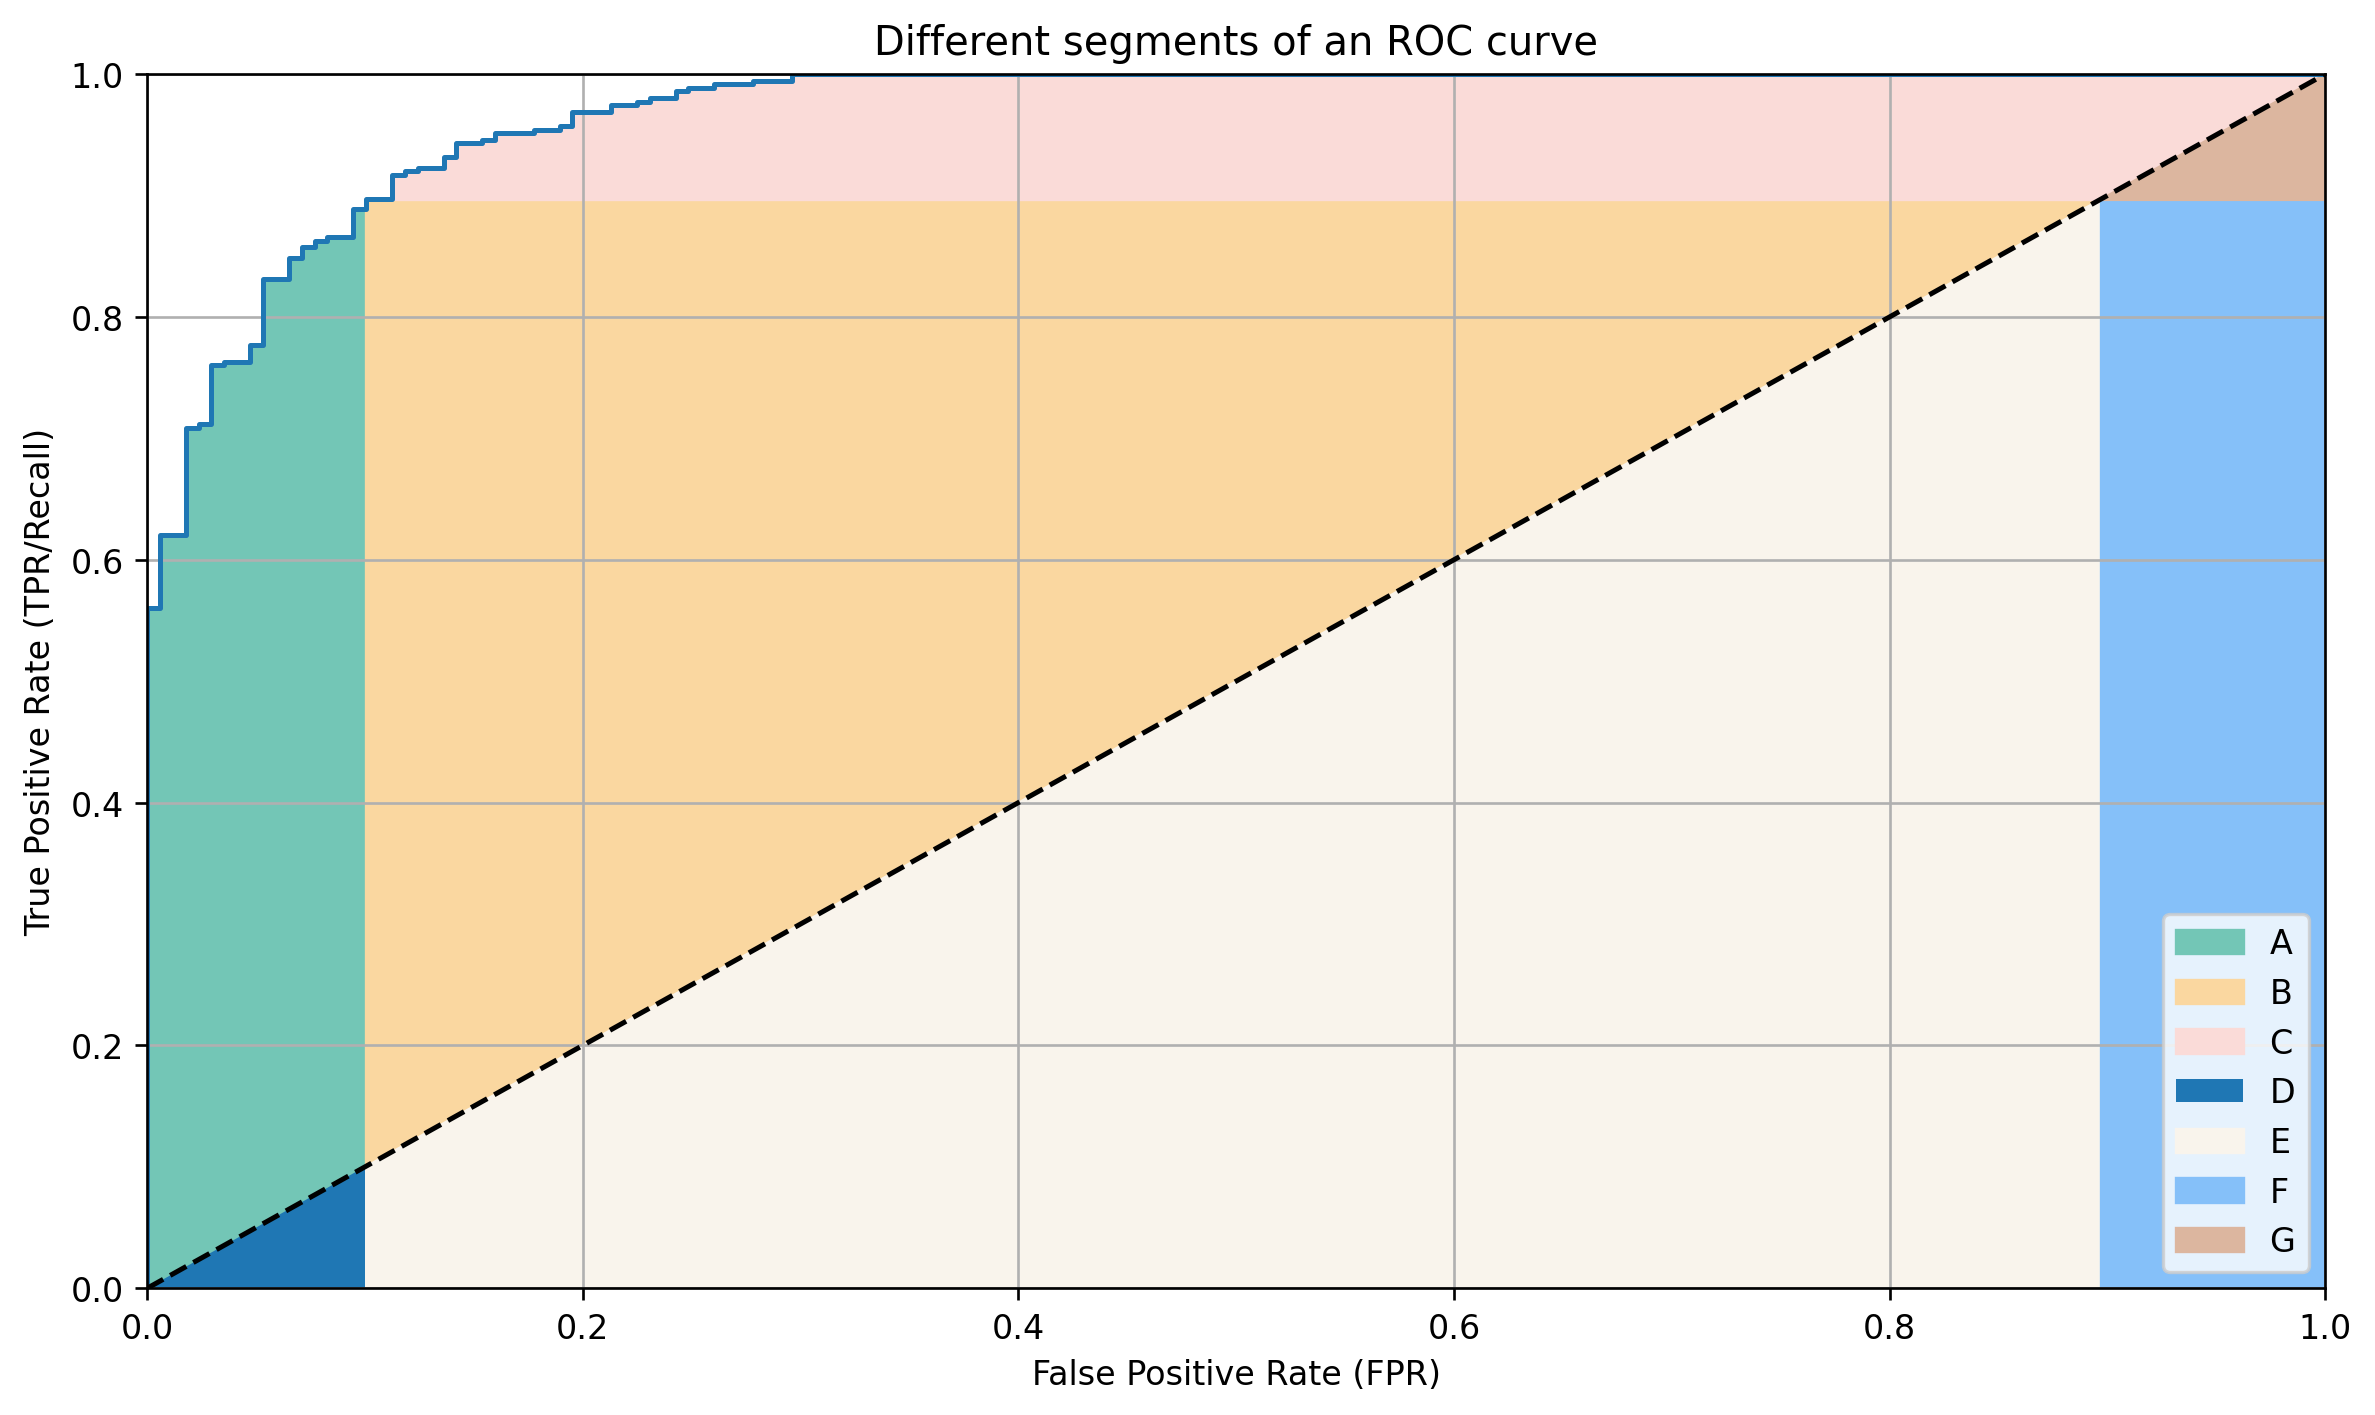

In [332]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], linestyle='--', color='k')
ax.fill_between(fpr[:idx], tpr[:idx], color='#73C6B6', label="A")
ax.fill_between(fpr[idx:], [tpr[idx]]*len(fpr[idx:]), color='#FAD7A0', label="B")
ax.fill_between(fpr[idx:], tpr[idx:], [tpr[idx]]*len(fpr[idx:]), color='#FADBD8', label="C")
ax.fill_between([0,fpr[idx]], [0,fpr[idx]], label="D")
ax.fill_between([fpr[idx], tpr[idx]], [fpr[idx], tpr[idx]], color='#F9F4EC', label='E')
ax.fill_between(tpr[idx:], [tpr[idx]]*len(fpr[idx:]), color='#85C0F9', label="F")
ax.fill_between(tpr[idx:], tpr[idx:], [tpr[idx]]*len(fpr[idx:]), color='#DCB69F', label="G")

ax.grid()
ax.legend(loc='lower right')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR/Recall)')
ax.set_title('Different segments of an ROC curve')
# ax.set_title(f'ROC Curve. AUC: {auc(fpr, tpr):0.3f}')
plt.tight_layout()
fig.savefig('../images/roc_segments.png', format='png', dpi=1200)

## Partial area metrics

### pAUC

In [15]:
fpr_cutoff = 0.1
idx = np.where(fpr>fpr_cutoff)[0].min()
idx+=1

In [16]:
pAUCc, pAUC, pAUCx, pAUCcn, pAUCn, pAUCxn, sPA = concordant_partial_AUC(fpr[:idx], tpr[:idx])

No handles with labels found to put in legend.


Text(0.5, 1.0, 'pAUC: 0.078 | FPR below: 0.10')

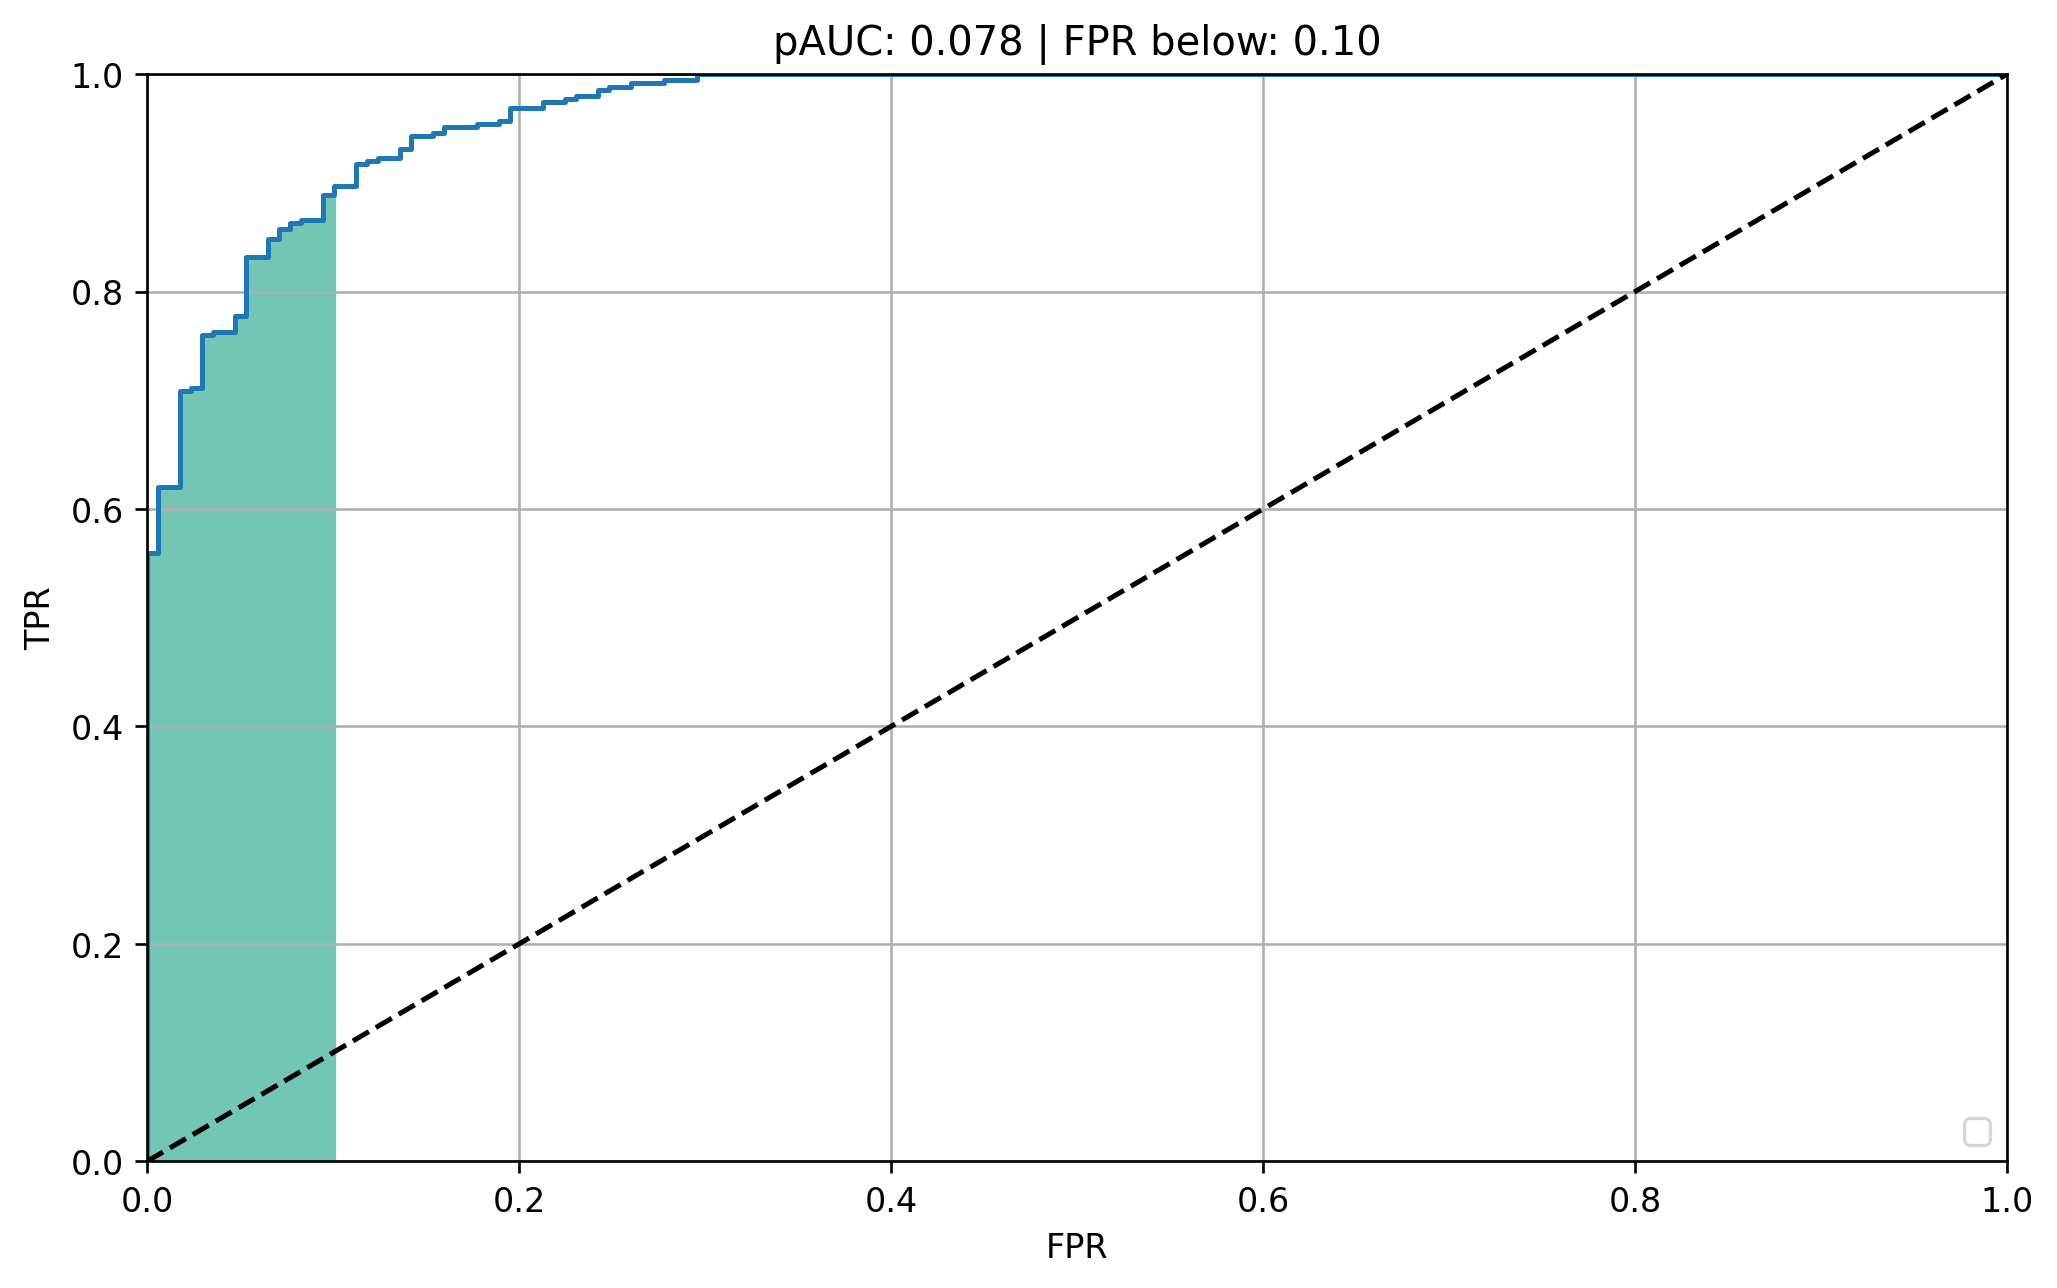

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], linestyle='--', color='k')
ax.fill_between(fpr[:idx], tpr[:idx], color='#73C6B6', label="")
ax.grid()
ax.legend(loc='lower right')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title(f'pAUC: {pAUC:0.3f} | FPR below: {fpr_cutoff:0.2f}')

### pAUCn

Text(0.5, 1.0, 'pAUCn: 0.773 @FPR: 0.10')

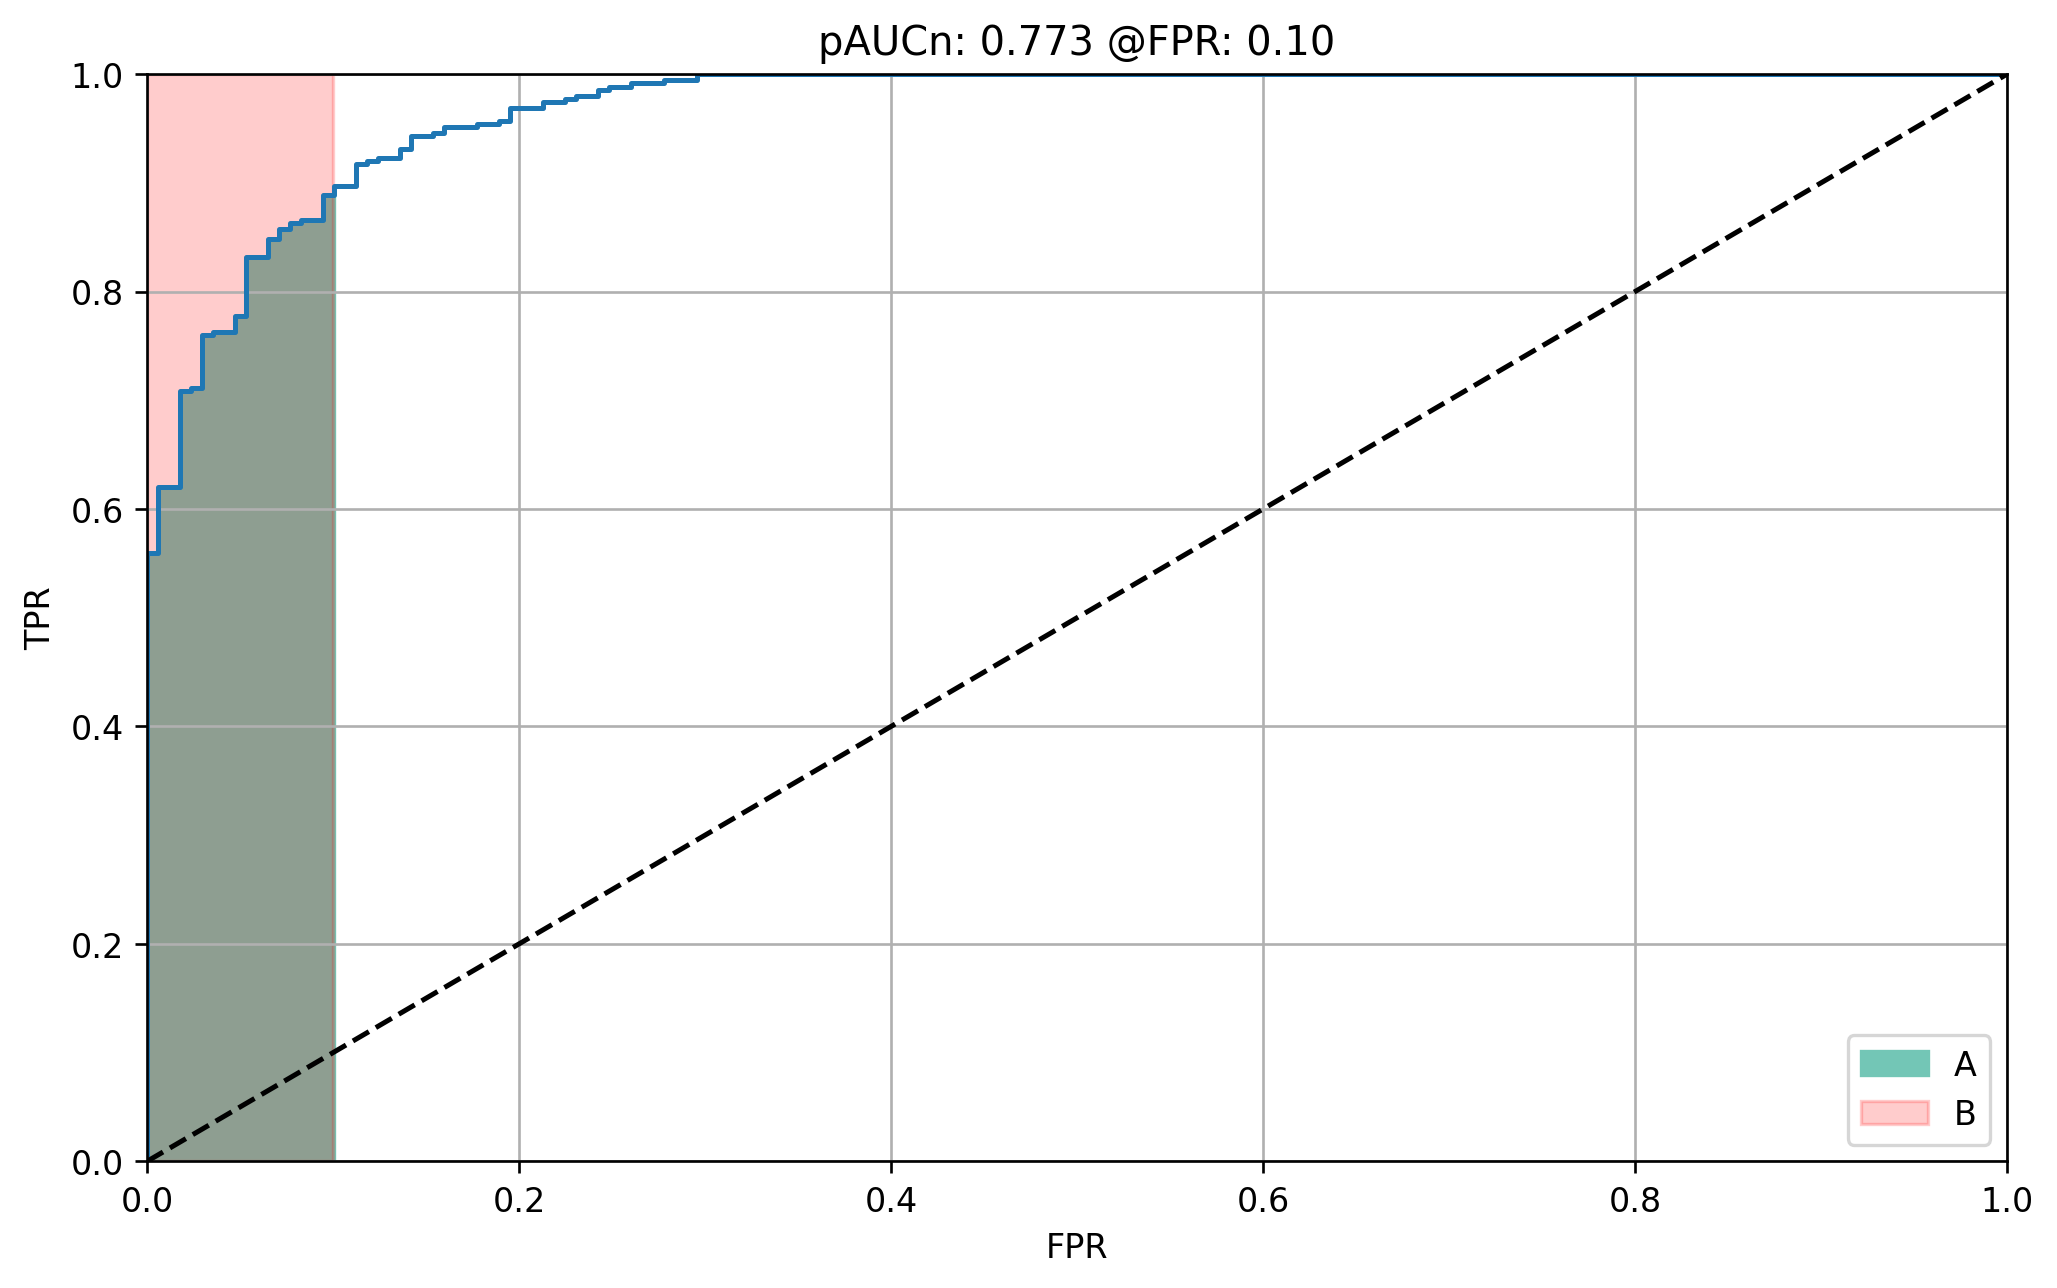

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], linestyle='--', color='k')
ax.fill_between(fpr[:idx], tpr[:idx], color='#73C6B6', label="A")
ax.fill_between([0, fpr_cutoff], [1, 1], color='r', label="B", alpha=0.2)
ax.grid()
ax.legend(loc='lower right')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title(f'pAUCn: {pAUCn:0.3f} @FPR: {fpr_cutoff:0.2f}')

### sPA

Text(0.5, 1.0, 'sPA: 0.880 @FPR: 0.10')

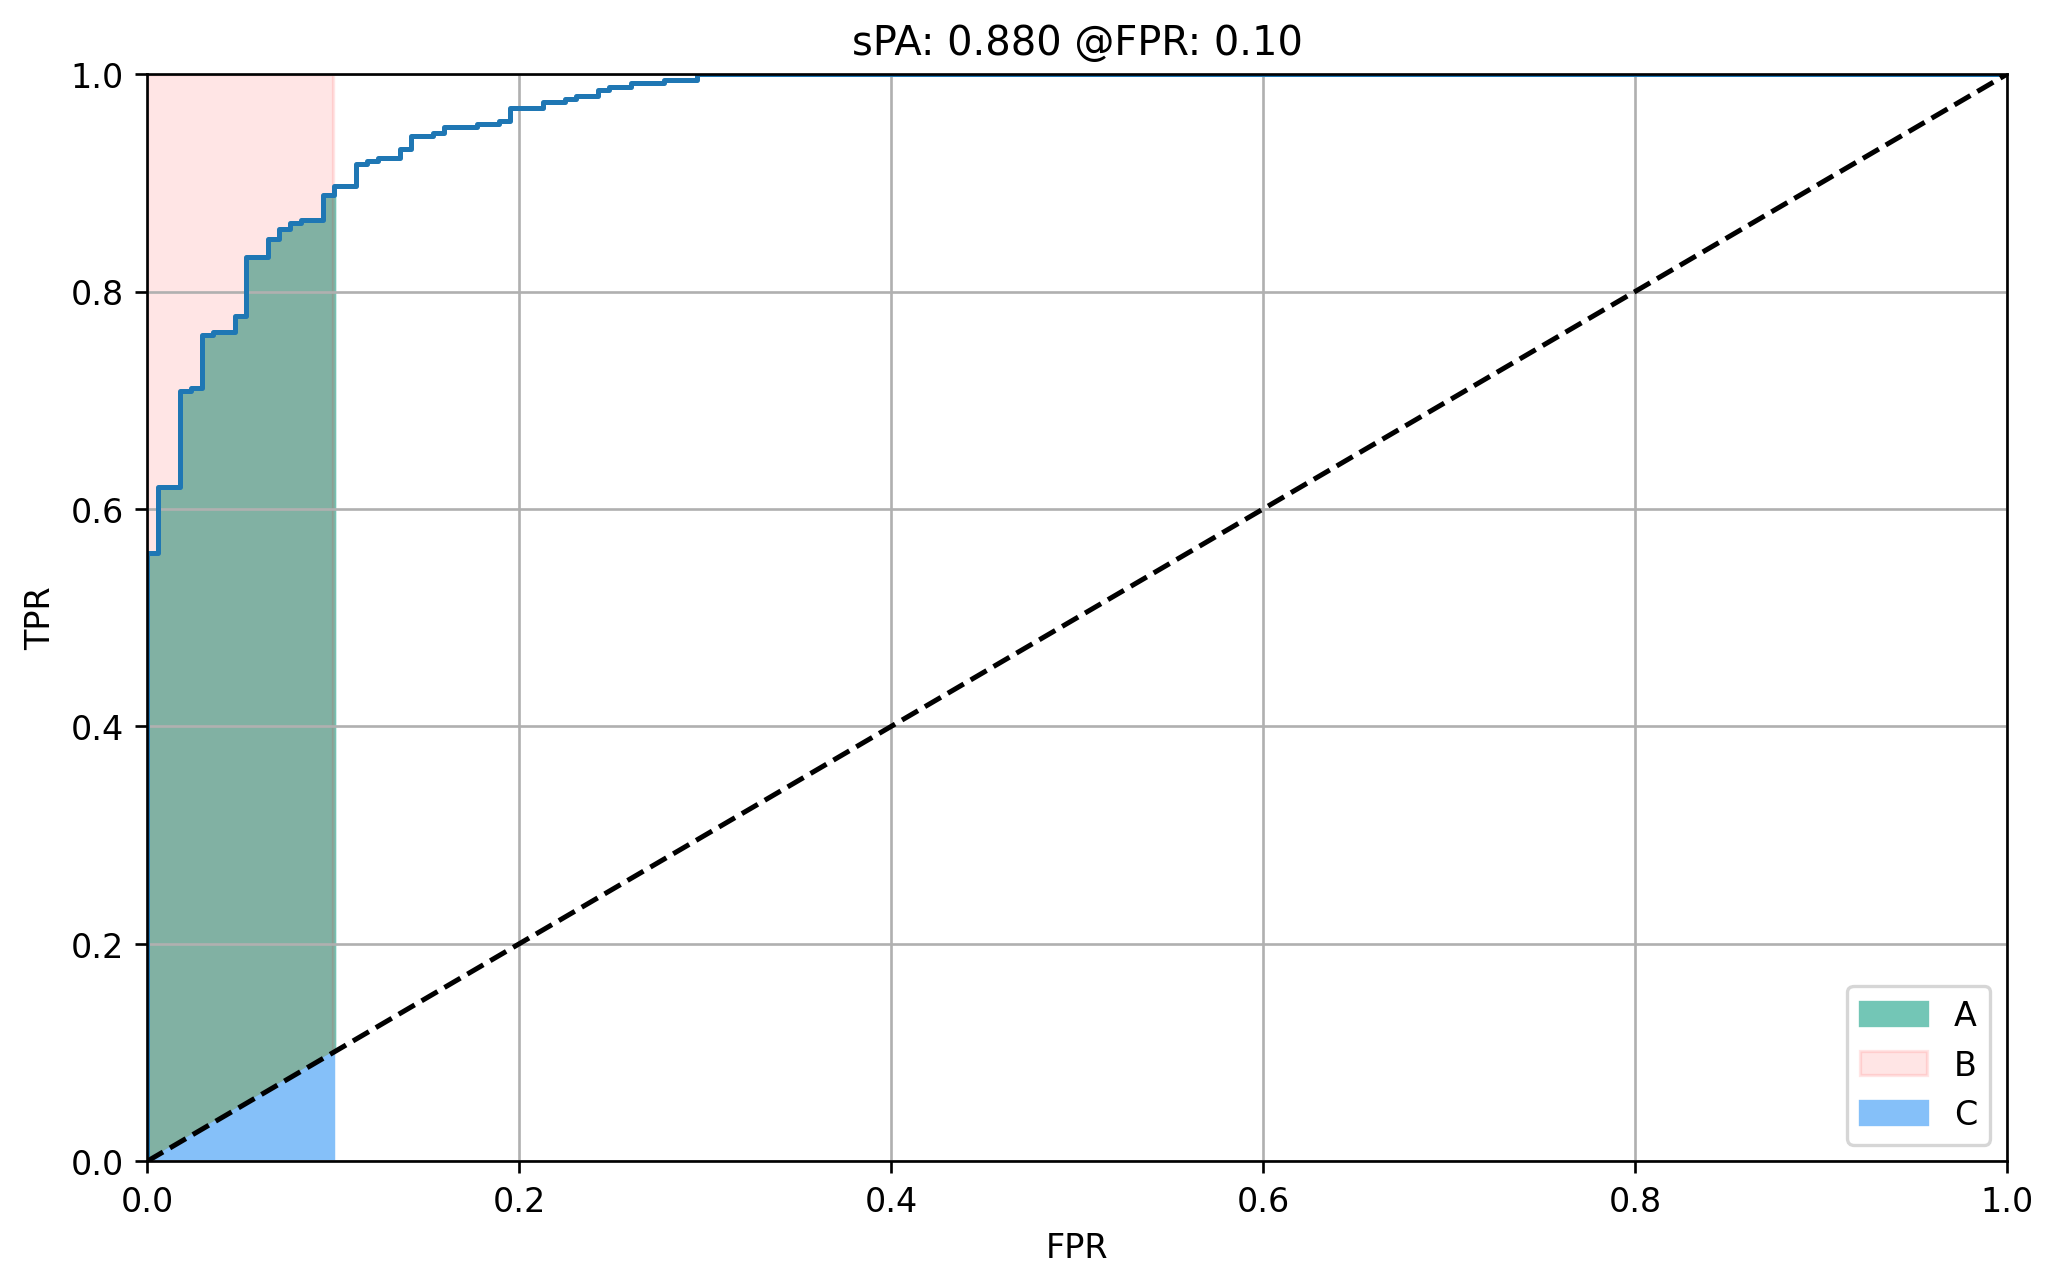

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], linestyle='--', color='k')
ax.fill_between(fpr[:idx], tpr[:idx], fpr[:idx], color='#73C6B6', label='A')
ax.fill_between([0,fpr_cutoff], [1,1], [0,fpr_cutoff], color='r', label='B',alpha=0.1)
ax.fill_between([0,fpr_cutoff], [0,fpr_cutoff], color='#85C0F9', label='C')
ax.grid()
ax.legend(loc='lower right')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title(f'sPA: {sPA:0.3f} @FPR: {fpr_cutoff:0.2f}')

### PAI

In [20]:
tpr_cutoff = 0.7
idx = np.where(tpr>tpr_cutoff)[0].min()
idx+=1

In [21]:
PAI = auc(fpr[idx:], tpr[idx:]) -\
tpr[idx]*(1-fpr[idx])
PAI=PAI/(1-tpr[idx])

Text(0.5, 1.0, 'PAI: 0.901 @TPR: 0.70')

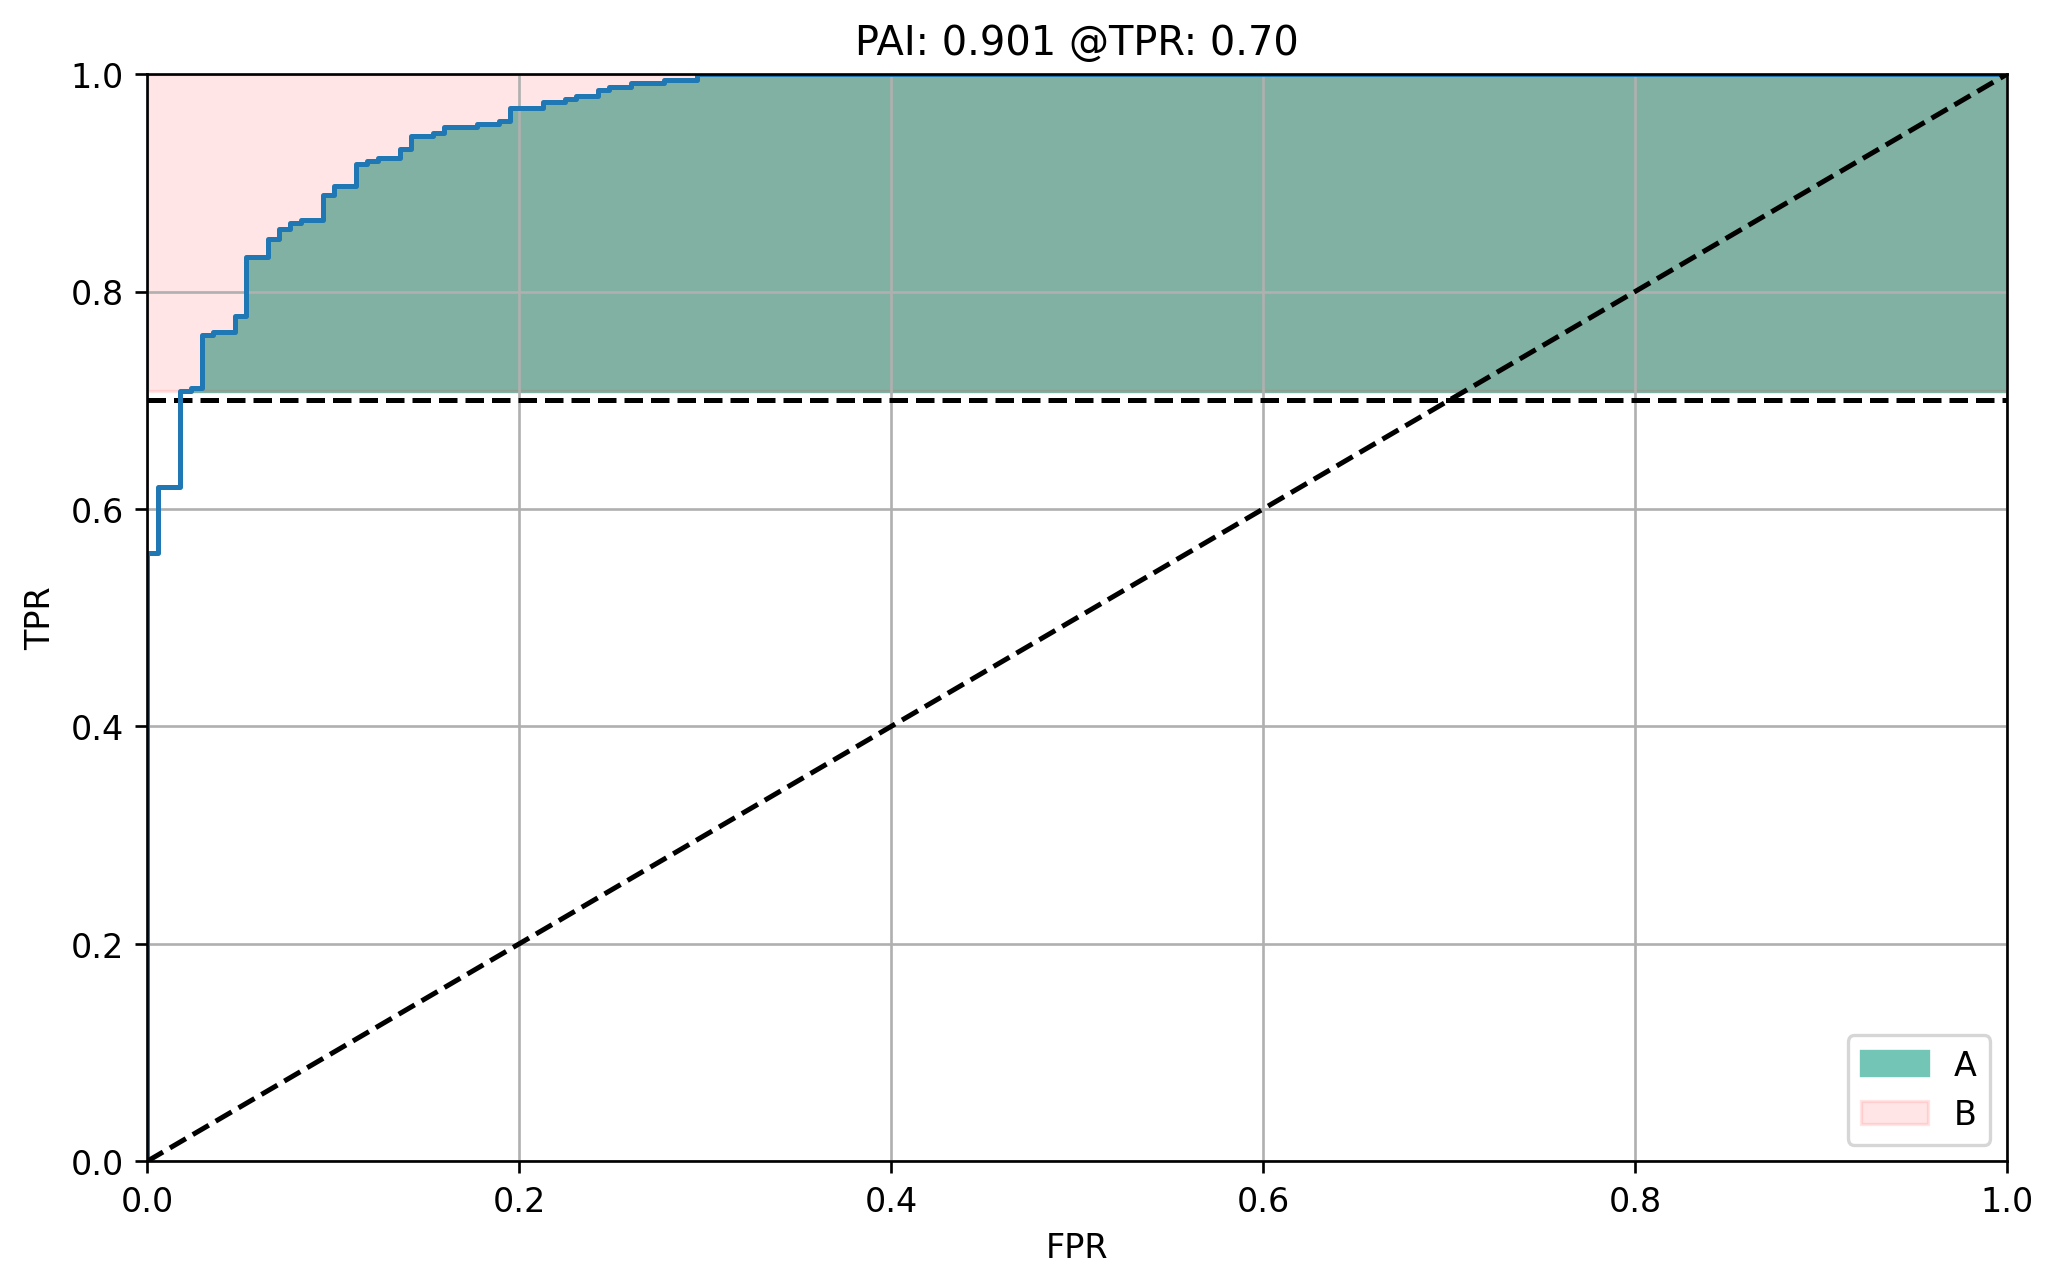

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], linestyle='--', color='k')
ax.hlines(tpr_cutoff, 0, 1, linestyle='--', color='k')
ax.fill_between(fpr[idx:], tpr[idx:], [tpr[idx]]*len(fpr[idx:]), color='#73C6B6', label='A')
ax.fill_between([0, 1], [tpr[idx], tpr[idx]], [1, 1], color='r', label="B", alpha=0.1)
ax.grid()
ax.legend(loc='lower right')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title(f'PAI: {PAI:0.3f} @TPR: {tpr_cutoff:0.2f}')

### tpAUCn

In [23]:
tpr_cutoff = 0.7
idx1 = np.where(tpr>tpr_cutoff)[0].min()
idx1+=1

In [24]:
fpr_cutoff = 0.1
idx2 = np.where(fpr>fpr_cutoff)[0].min()
idx2+=1

In [25]:
tpAUC = auc(fpr[idx1:idx2], tpr[idx1:idx2]) -\
        tpr_cutoff*(fpr_cutoff-fpr[idx1])
tpAUC = tpAUC/((tpr[idx2]-tpr_cutoff)*(fpr_cutoff-fpr[idx1]))  # normalize

Text(0.5, 1.0, 'tpAUCn: 0.6275 @FPR < 0.10 @TPR > 0.70')

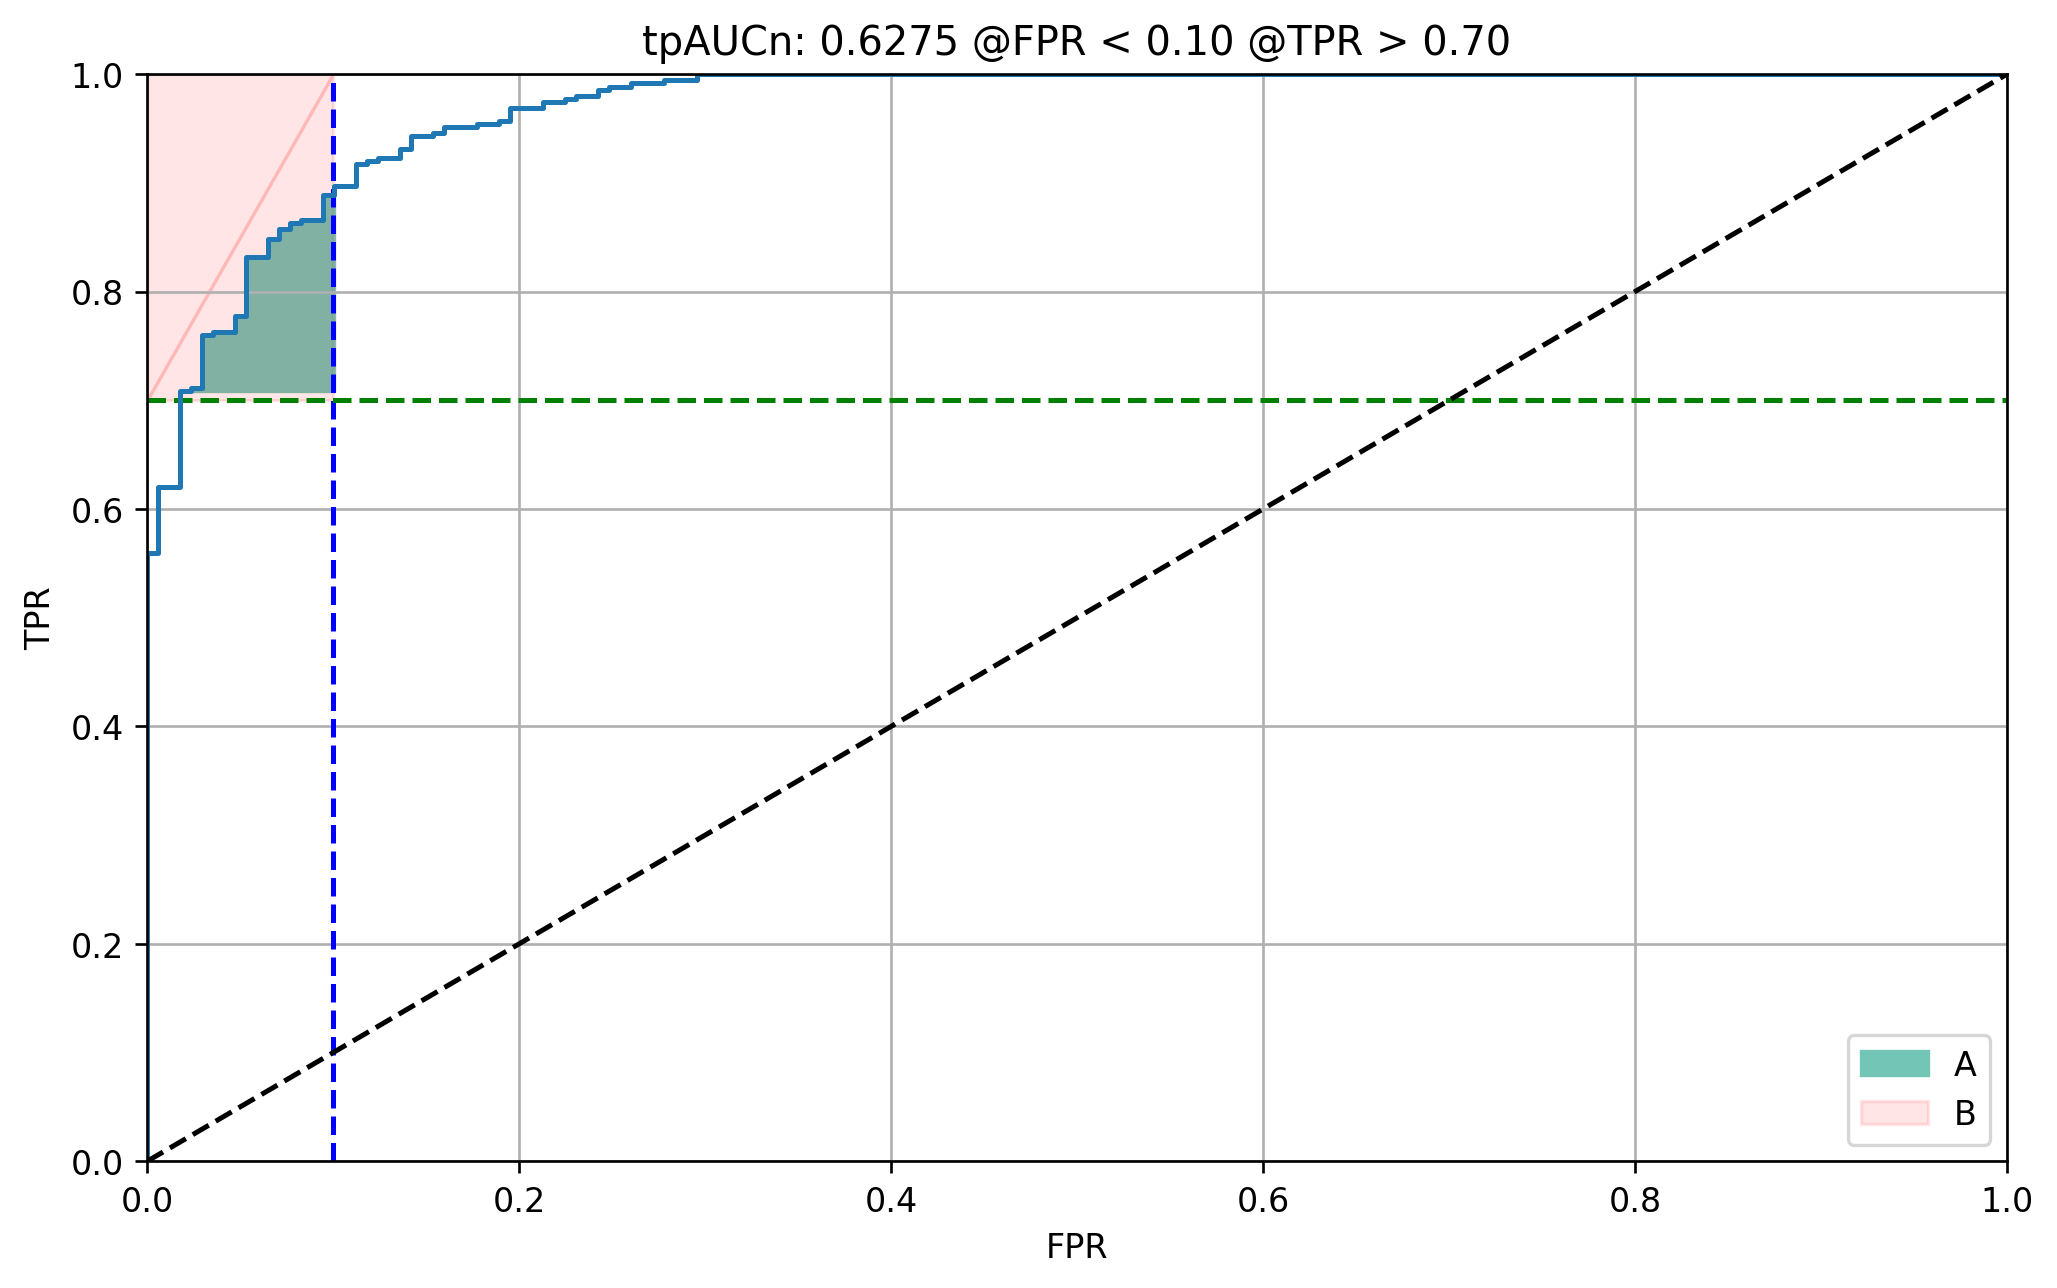

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], linestyle='--', color='k')
ax.vlines(fpr_cutoff, 0, 1, linestyle='--', color='b')
ax.hlines(tpr_cutoff, 0, 1, linestyle='--', color='g')
ax.fill_between(fpr[idx1:idx2], tpr[idx1:idx2], [tpr[idx1]]*(idx2-idx1), color='#73C6B6', label='A')

ax.fill_between([0, fpr_cutoff], [tpr_cutoff, 1], [1, 1], color='r', alpha=0.1)
ax.fill_between([0, fpr_cutoff], [tpr_cutoff, 1], [tpr_cutoff, tpr_cutoff], color='r', label="B", alpha=0.1)

ax.grid()
ax.legend(loc='lower right')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title(f'tpAUCn: {tpAUC:0.4f} @FPR < {fpr_cutoff:0.2f} @TPR > {tpr_cutoff:0.2f}')

### pAUCc

In [27]:
assert (pAUCx+pAUC)/2 == pAUCc

In [28]:
fpr_cutoff1 = 0.1
idx1 = np.where(fpr>=fpr_cutoff1)[0].min()
idx1=idx1+1

fpr_cutoff2 = 0.2
idx2 = np.where(fpr>=fpr_cutoff2)[0].min()
idx2=idx2+1

In [29]:
pAUCc, pAUC, pAUCx, pAUCcn, pAUCn, pAUCxn, sPA = concordant_partial_AUC(fpr[idx1:idx2], tpr[idx1:idx2])

Text(0.5, 1.0, 'pAUCc: 0.083 @FPR b/w 0.10 & 0.20')

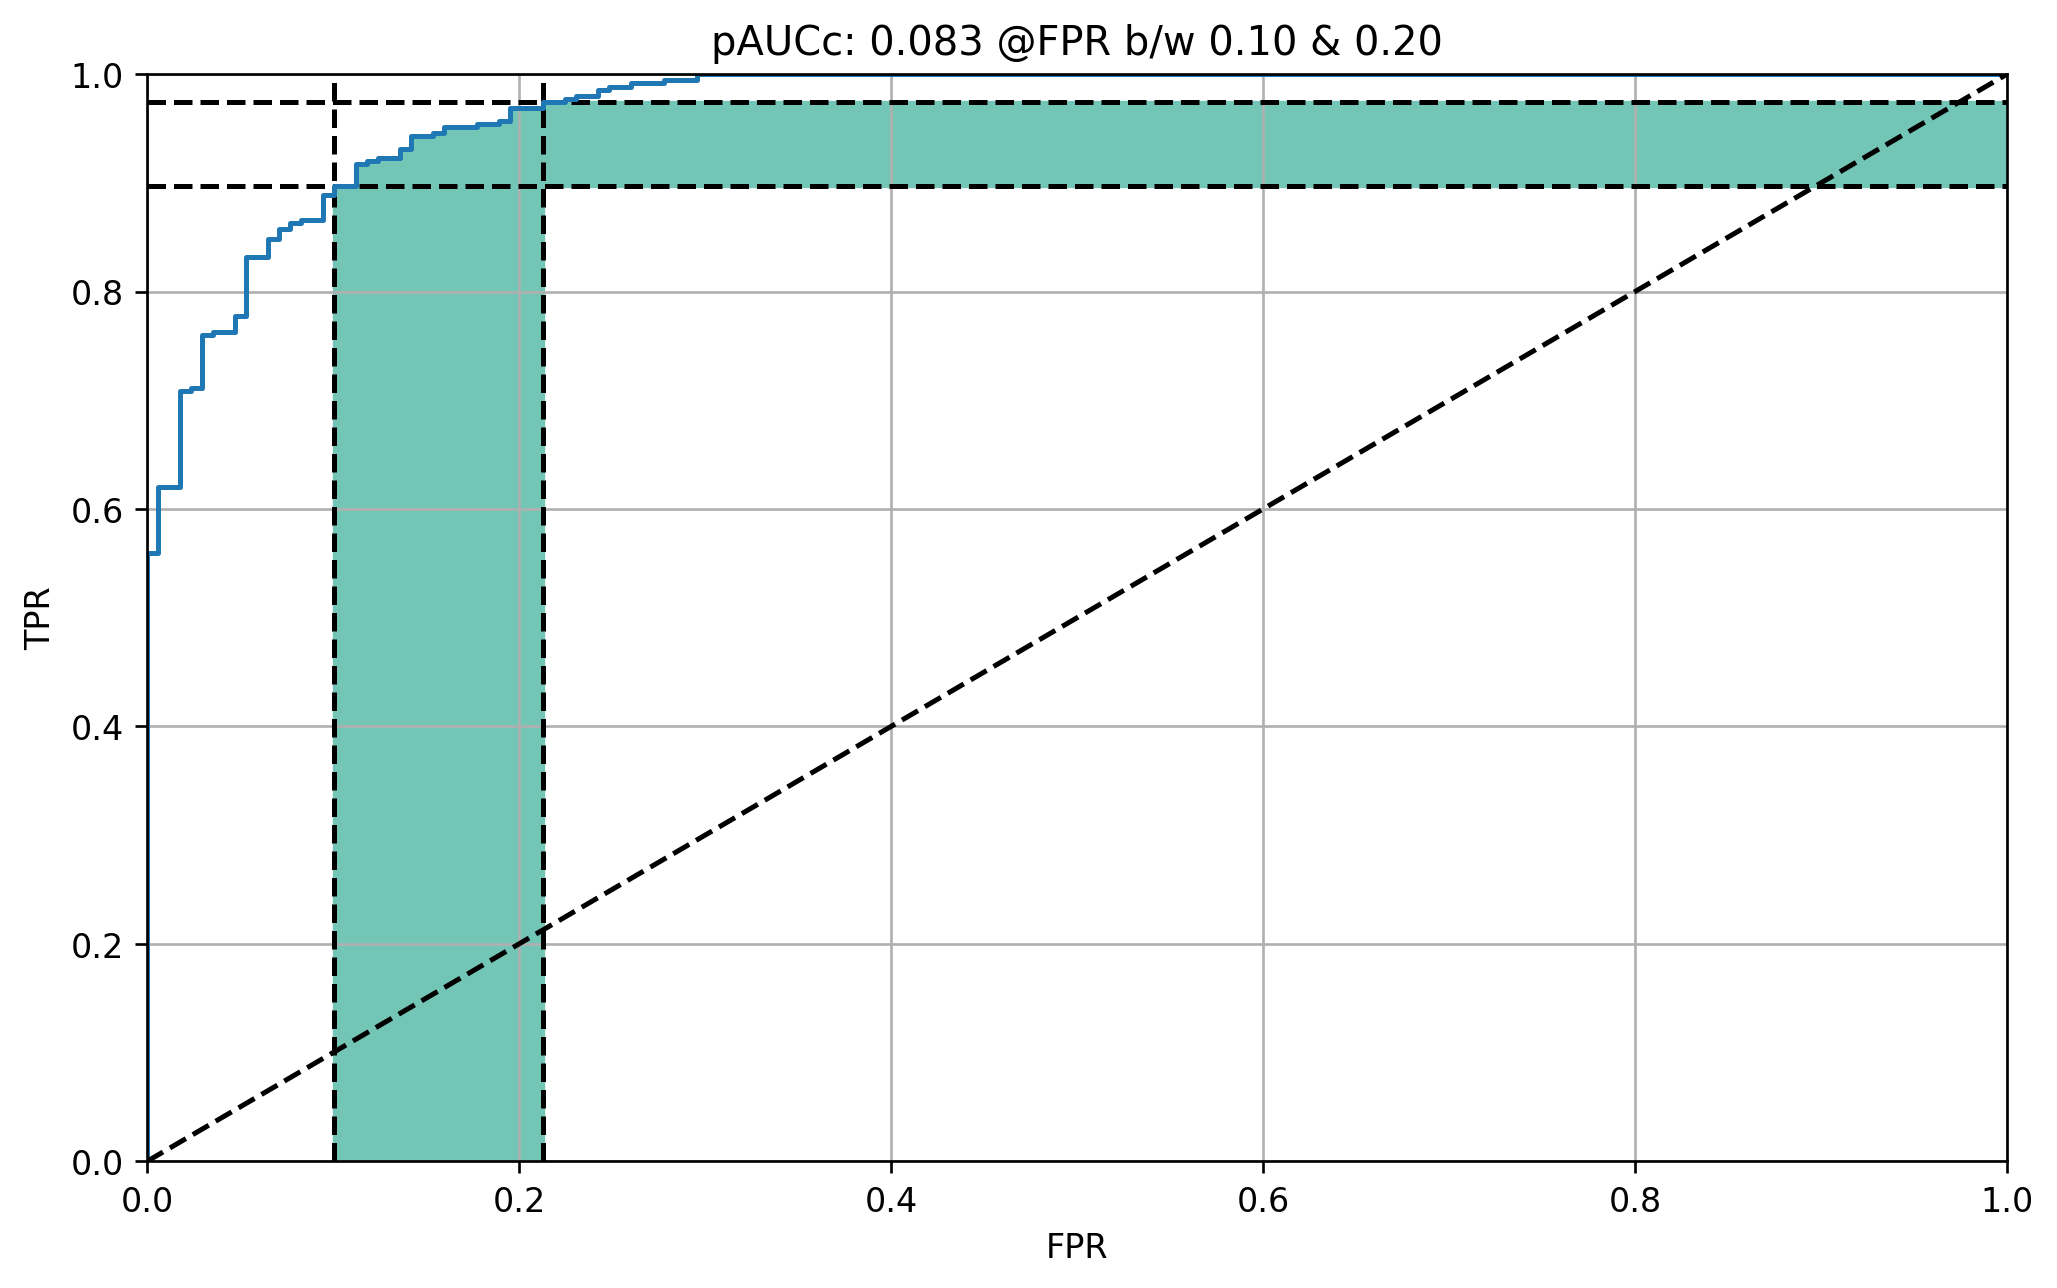

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], linestyle='--', color='k')
ax.vlines(fpr[idx1], 0, 1, linestyle='--', color='k')
ax.vlines(fpr[idx2], 0, 1, linestyle='--', color='k')
ax.fill_between(fpr[idx1:idx2], tpr[idx1:idx2], color='#73C6B6')

ax.hlines(tpr[idx1], 0, 1, linestyle='--', color='k')
ax.hlines(tpr[idx2], 0, 1, linestyle='--', color='k')
ax.fill_between(fpr[idx1:], 
                [min(i, tpr[idx2]) for i in tpr[idx1:]],
                [tpr[idx1]]*len(fpr[idx1:]),
                color='#73C6B6')

ax.grid()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title(f'pAUCc: {pAUCc:0.3f} @FPR b/w {fpr_cutoff1:0.2f} & {fpr_cutoff2:0.2f}')

### pAUCcn

In [31]:
assert (pAUCxn+pAUCn)/2 == pAUCcn

In [32]:
fpr_cutoff1 = 0.1
idx1 = np.where(fpr>=fpr_cutoff1)[0].min()
idx1=idx1+1

fpr_cutoff2 = 0.2
idx2 = np.where(fpr>=fpr_cutoff2)[0].min()
idx2=idx2+1

In [33]:
pAUCc, pAUC, pAUCx, pAUCcn, pAUCn, pAUCxn, sPA = concordant_partial_AUC(fpr[idx1:idx2], tpr[idx1:idx2])

Text(0.5, 1.0, 'pAUCcn: 0.898 @FPR b/w 0.10 & 0.20')

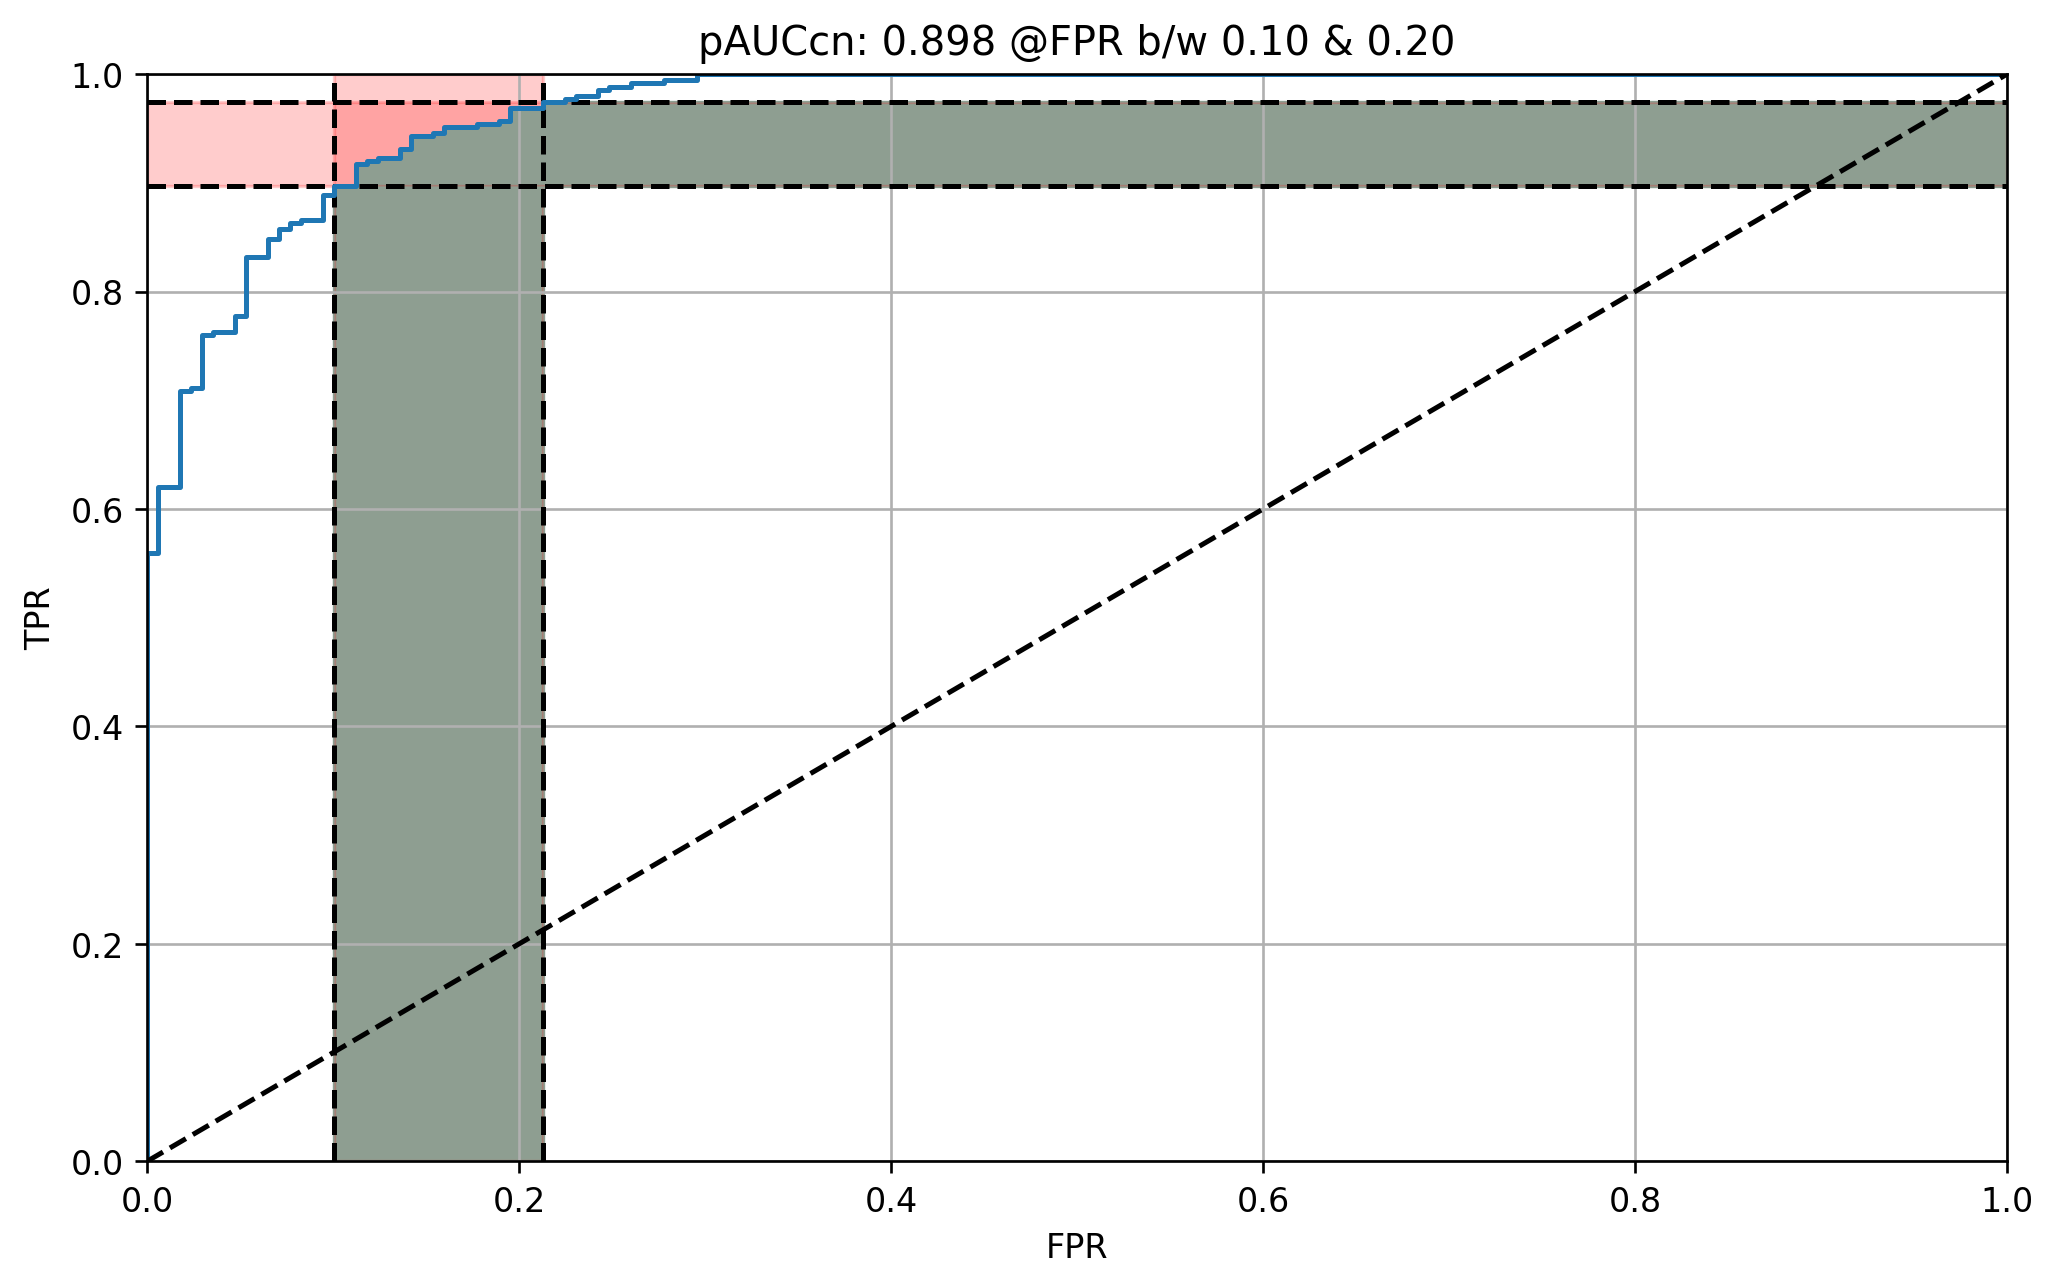

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], linestyle='--', color='k')
ax.vlines(fpr[idx1], 0, 1, linestyle='--', color='k')
ax.vlines(fpr[idx2], 0, 1, linestyle='--', color='k')
ax.fill_between(fpr[idx1:idx2], tpr[idx1:idx2], color='#73C6B6')
ax.fill_between([fpr[idx1], fpr[idx2]], [1,1], color='r', alpha=0.2)

ax.hlines(tpr[idx1], 0, 1, linestyle='--', color='k')
ax.hlines(tpr[idx2], 0, 1, linestyle='--', color='k')
ax.fill_between(fpr[idx1:], 
                [min(i, tpr[idx2]) for i in tpr[idx1:]],
                [tpr[idx1]]*len(fpr[idx1:]),
                color='#73C6B6')
ax.fill_between([0,1], [tpr[idx1], tpr[idx1]], [tpr[idx2], tpr[idx2]], color='r', alpha=0.2)

ax.grid()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title(f'pAUCcn: {pAUCcn:0.3f} @FPR b/w {fpr_cutoff1:0.2f} & {fpr_cutoff2:0.2f}')

### HAUC

In [35]:
hauc_se_idx = np.argmin(abs(fpr - (1-tpr)))
hauc_sp_idx = np.argmin(abs(tpr - (1-fpr)))

In [36]:
hauc_se_idx, hauc_sp_idx

(28, 28)

In [37]:
tri = ((1-fpr[hauc_se_idx])**2)/2
tri

0.40446763068520014

In [38]:
pAUCc, pAUC, pAUCx, pAUCcn, pAUCn, pAUCxn, sPA = concordant_partial_AUC(fpr[:hauc_se_idx], tpr[:hauc_se_idx])

In [39]:
# not normalized
PAI = auc(fpr[hauc_se_idx:], tpr[hauc_se_idx:]) -\
tpr[hauc_se_idx]*(1-fpr[hauc_se_idx])
PAI

0.08464919695688922

Text(0.5, 1.0, 'HAUCsp: 0.482, HAUCse: 0.489 @ FPR = 1-TPR = 0.10')

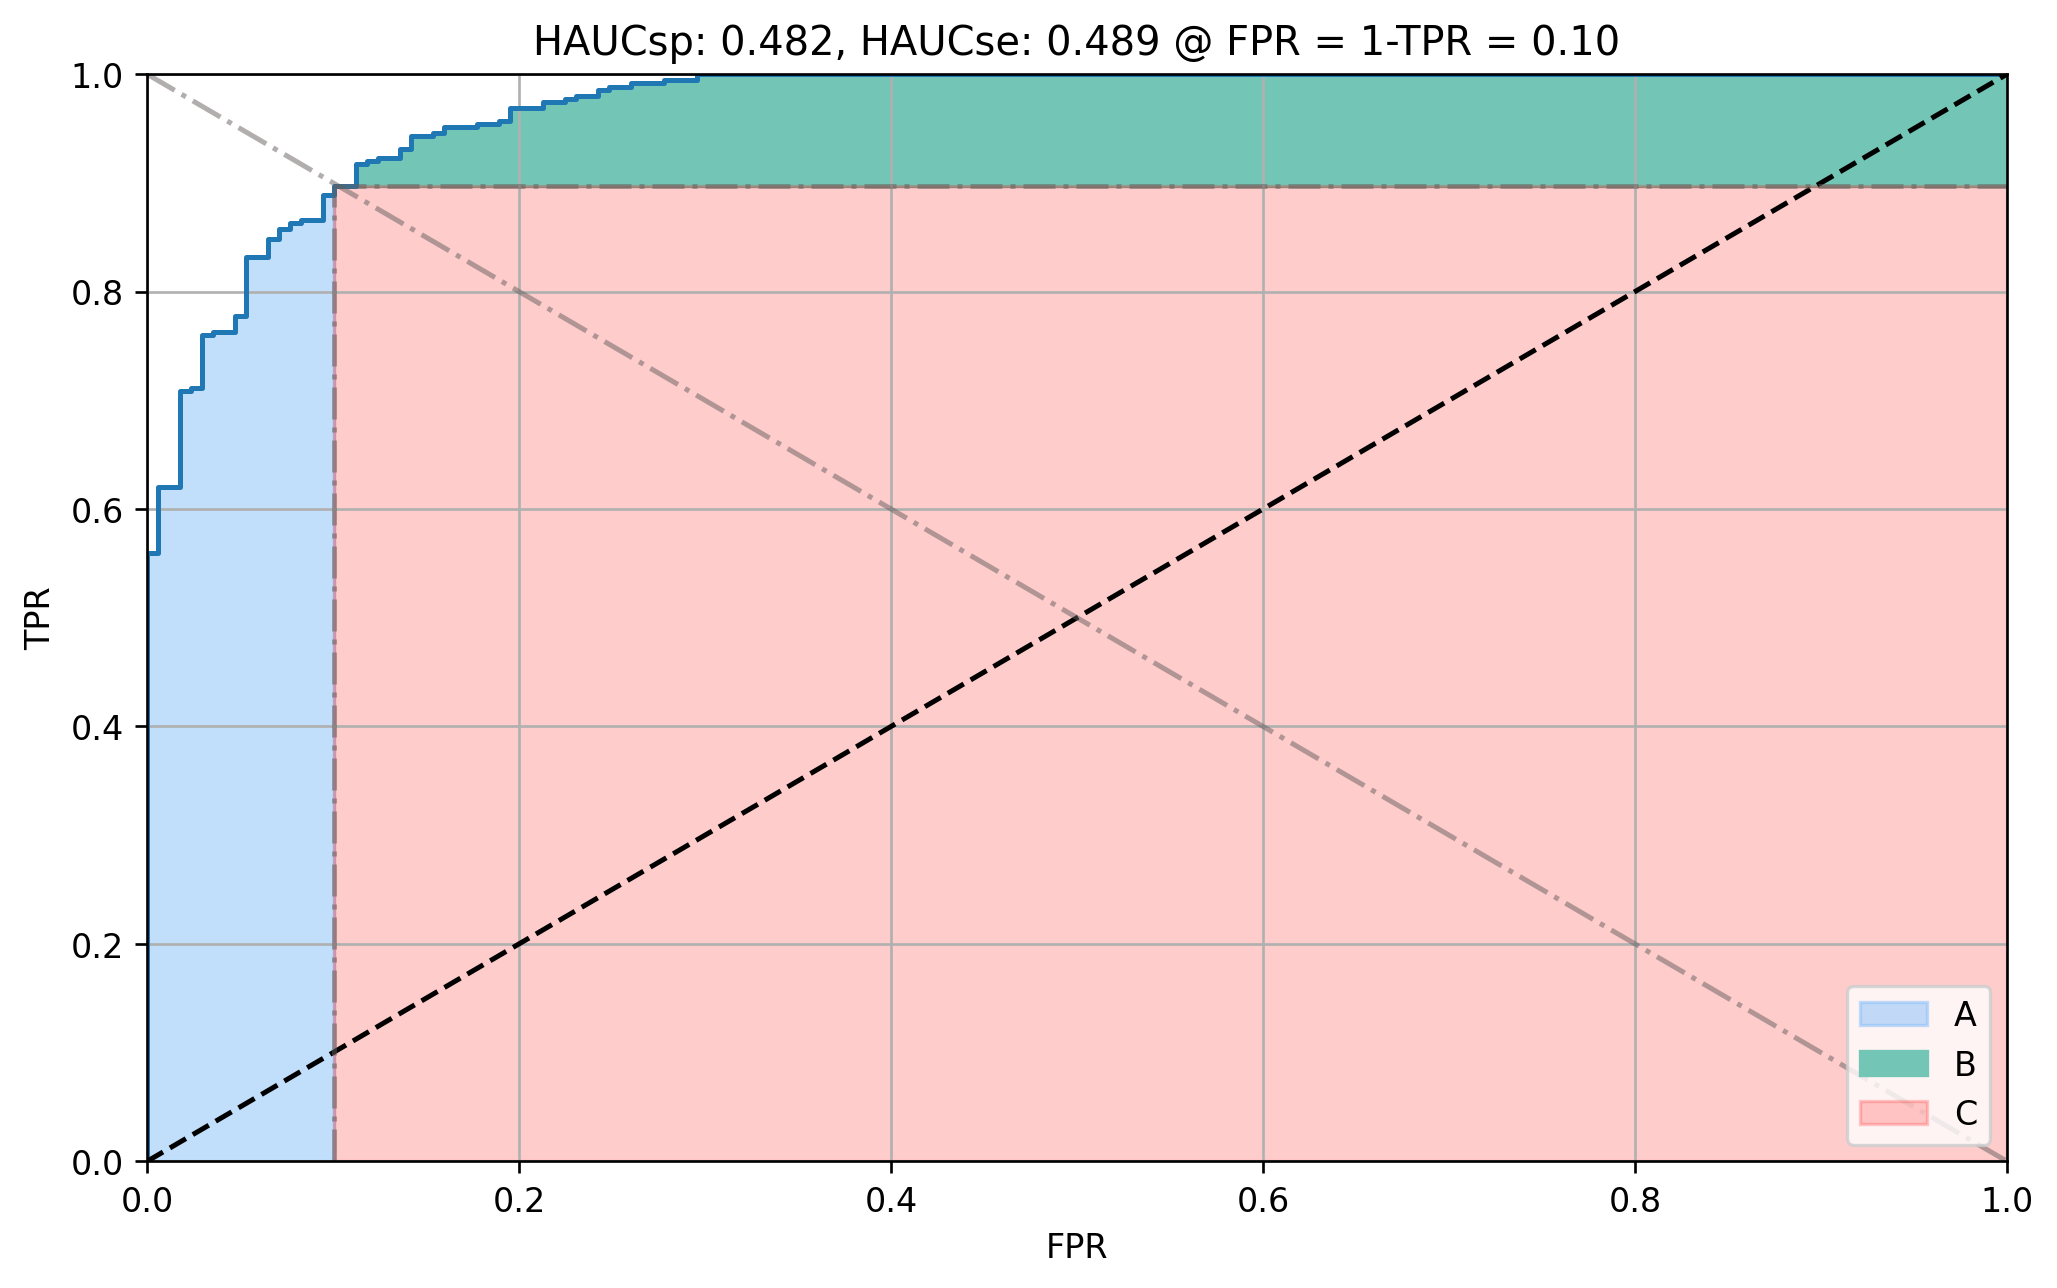

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(fpr, tpr)
ax.plot([0,1], [0,1], linestyle='--', color='k')
ax.plot([0,1], [1,0], linestyle='-.', color='#645E5D', alpha=0.5)
ax.plot([fpr[hauc_se_idx], fpr[hauc_se_idx]], [0, tpr[hauc_se_idx]], linestyle='-.', color='#645E5D', alpha=0.5)
ax.plot([fpr[hauc_se_idx], 1], [tpr[hauc_se_idx], tpr[hauc_se_idx]], linestyle='-.', color='#645E5D', alpha=0.5)

ax.fill_between(fpr[:hauc_se_idx], tpr[:hauc_se_idx], color='#85C0F9', label="A", alpha=0.5)
ax.fill_between(fpr[hauc_se_idx:], tpr[hauc_se_idx:], [tpr[hauc_se_idx]]*len(fpr[hauc_se_idx:]), color='#73C6B6', label='B')
ax.fill_between([fpr[hauc_se_idx],1], [tpr[hauc_se_idx], tpr[hauc_se_idx]], color='r', label='C', alpha=0.2)

ax.grid()
ax.legend(loc='lower right')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title(f'HAUCsp: {(pAUC+tri):0.3f}, HAUCse: {(PAI+tri):0.3f} @ FPR = 1-TPR = {fpr[hauc_se_idx]:0.2f}')

## Comparison Study

### Two classifiers with high and similar AUCs but different performance at low FPRs

In [112]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

In [288]:
X, y = make_classification(
    n_samples=100000, 
    n_features=10,
    n_informative=5,
    n_redundant=5,
    n_repeated=0,
    class_sep=1.5,
    n_clusters_per_class=1,
    weights=[0.99, 0.01], # Highly imbalanced
    flip_y=0,
    random_state=15,
    
)

In [289]:
len(X), sum(y)/y.shape[0]

(100000, 0.01)

In [290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [291]:
model= LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

y_hat_1 = model.predict_proba(X_test)[:,1]

In [292]:
roc_auc_score(y_test, y_hat_1)

0.9977796428305835

In [293]:
model= CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)

y_hat_2 = model.predict_proba(X_test)[:,1]

In [294]:
roc_auc_score(y_test, y_hat_2)

0.9996176354084431

In [295]:
fpr_1, tpr_1, thres_1 = roc_curve(y_test, y_hat_1)
fpr_2, tpr_2, thres_2 = roc_curve(y_test, y_hat_2)

Text(0.5, 0.98, 'ROC Curves. LogisticRegression. AUC: 0.9978 VS. CatBoostClassifier. AUC: 0.9996')

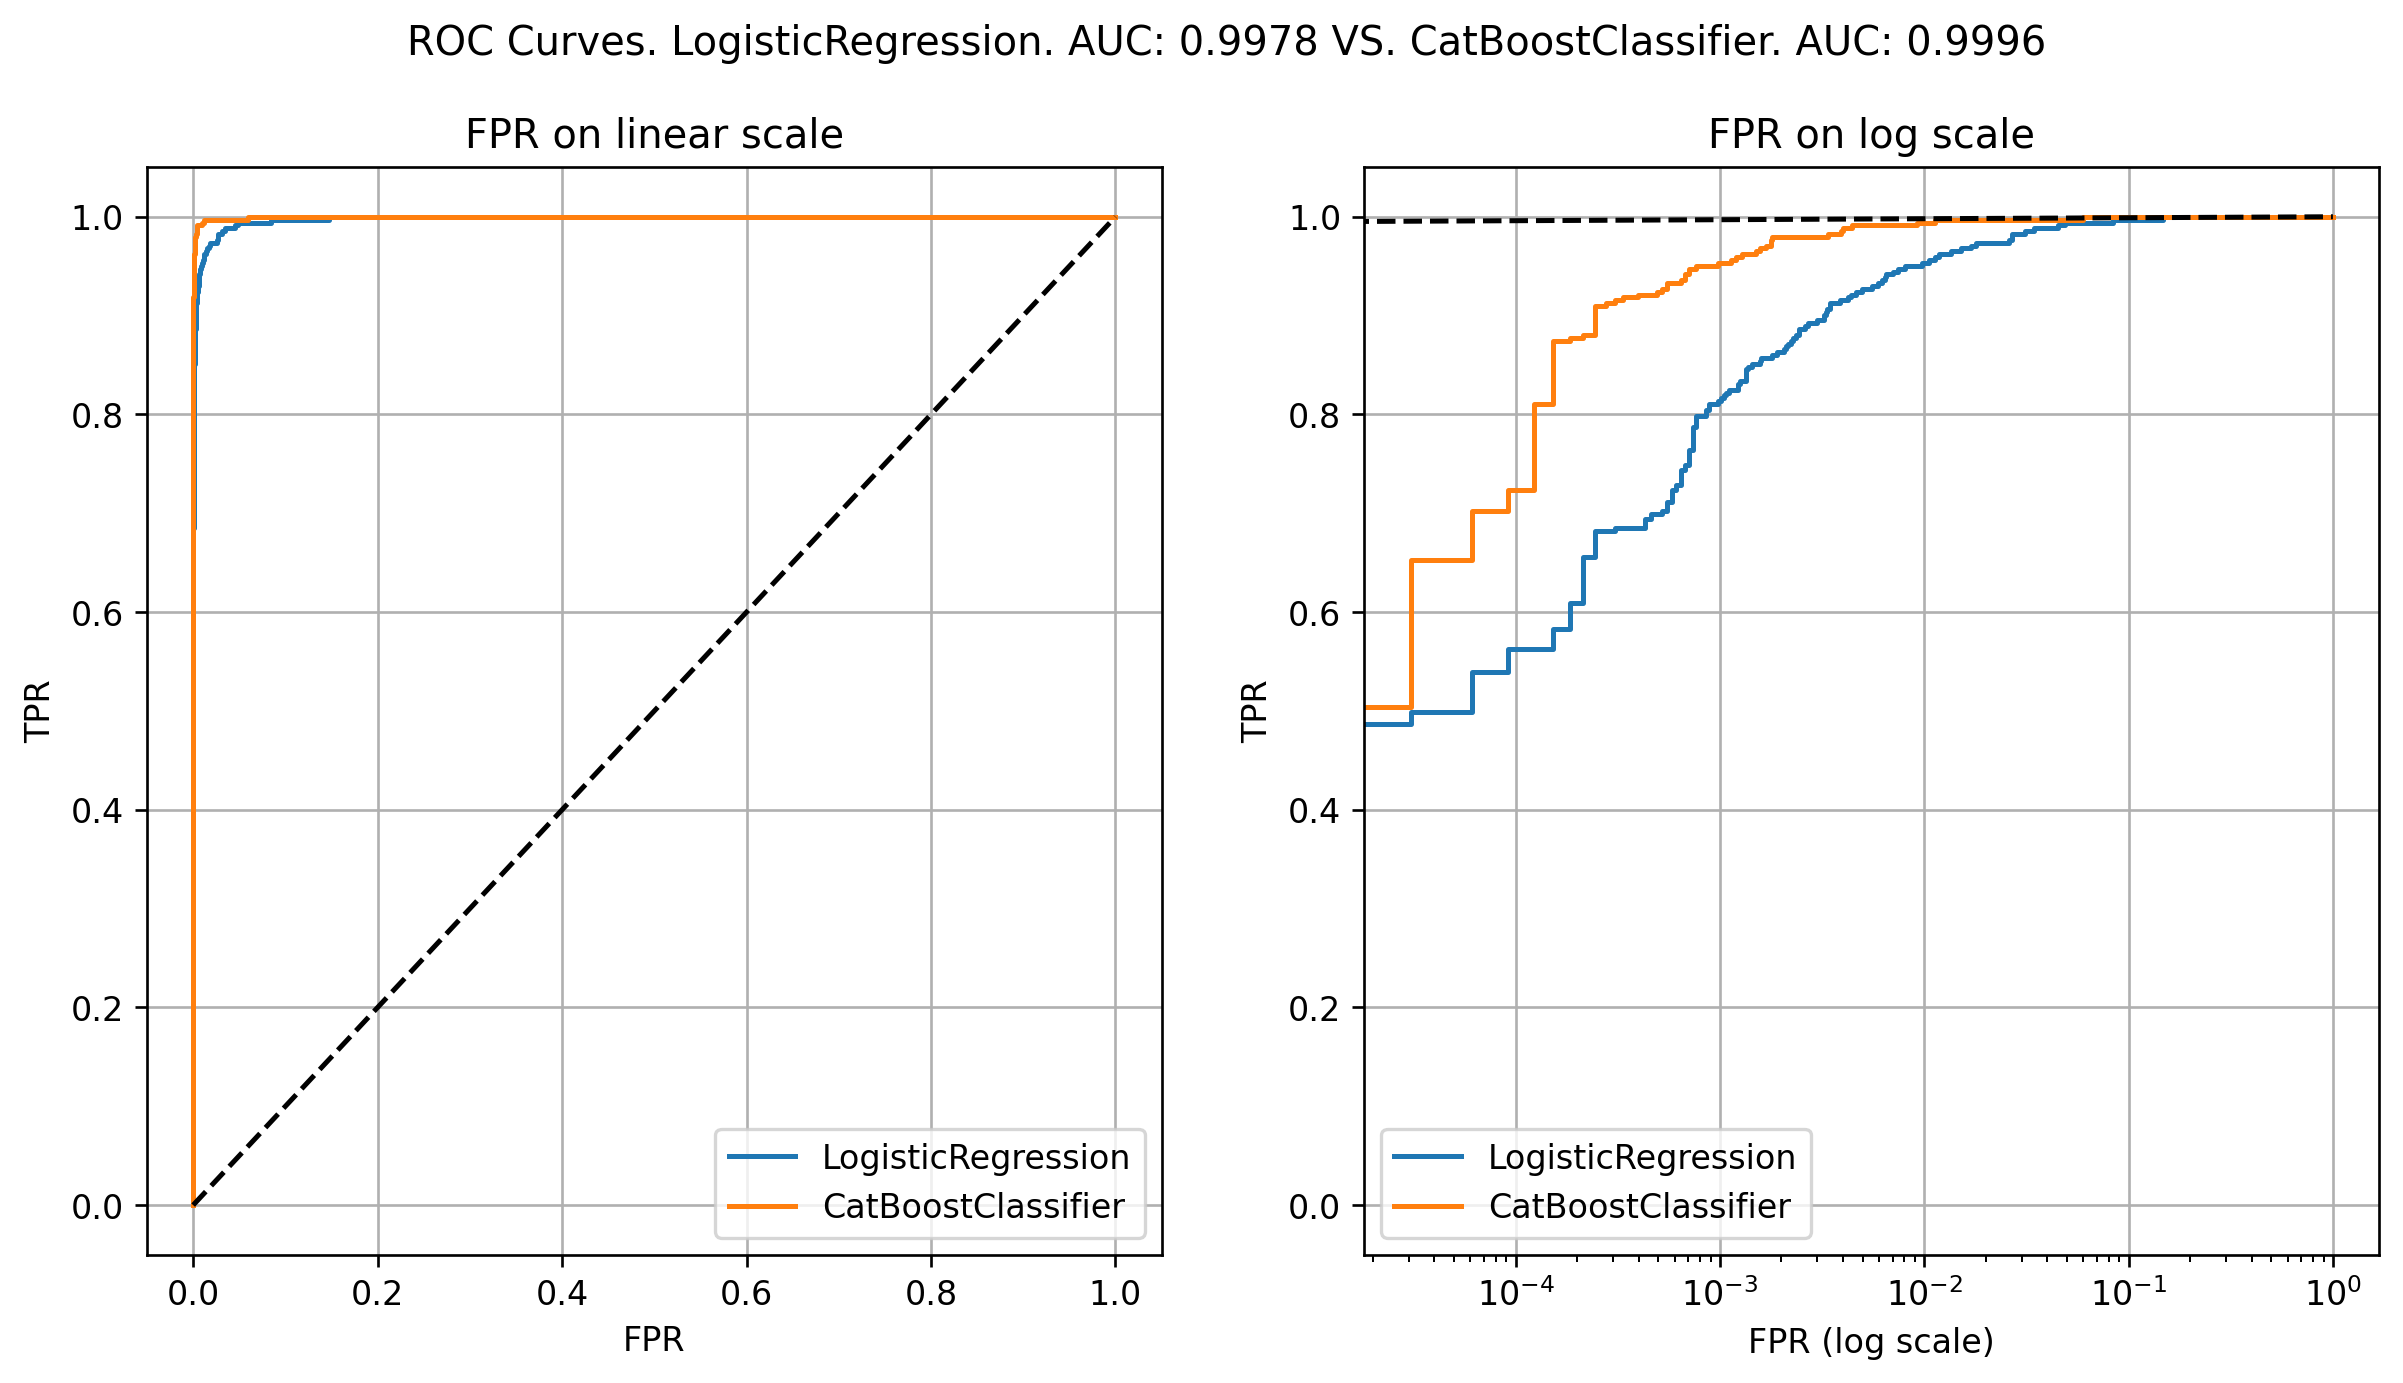

In [333]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax.plot(fpr_1, tpr_1, label=f'LogisticRegression')
ax.plot(fpr_2, tpr_2, label=f'CatBoostClassifier')
ax.plot([0,1], [0,1], linestyle='--', color='k')

ax.grid()
ax.legend()
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('FPR on linear scale')


## LOG 
ax2.plot(fpr_1, tpr_1, label=f'LogisticRegression')
ax2.plot(fpr_2, tpr_2, label=f'CatBoostClassifier')
ax2.plot([0,1], [0,1], linestyle='--', color='k')

ax2.grid()
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
ax2.set_xscale('log')
ax2.legend()
ax2.set_xlabel('FPR (log scale)')
ax2.set_ylabel('TPR')
ax2.set_title('FPR on log scale')

plt.suptitle(f'ROC Curves. LogisticRegression. AUC: {auc(fpr_1, tpr_1):0.4f} VS. CatBoostClassifier. AUC: {auc(fpr_2, tpr_2):0.4f}')

In [302]:
fpr_cutoff = 0.01
idx_1 = np.where(fpr_1>fpr_cutoff)[0].min()
idx_1+=1

pAUCc, pAUC, pAUCx, pAUCcn, pAUCn_1, pAUCxn, sPA_1 = concordant_partial_AUC(fpr_1[:idx_1], tpr_1[:idx_1])
pAUCn_1, sPA_1

(0.8994551589898765, 0.949462177388872)

In [304]:
fpr_cutoff = 0.01
idx_2 = np.where(fpr_2>fpr_cutoff)[0].min()
idx_2+=1

pAUCc, pAUC, pAUCx, pAUCcn, pAUCn_2, pAUCxn, sPA_2 = concordant_partial_AUC(fpr_2[:idx_2], tpr_2[:idx_2])
pAUCn_2, sPA_2

(0.9785193953019122, 0.9891990067651246)

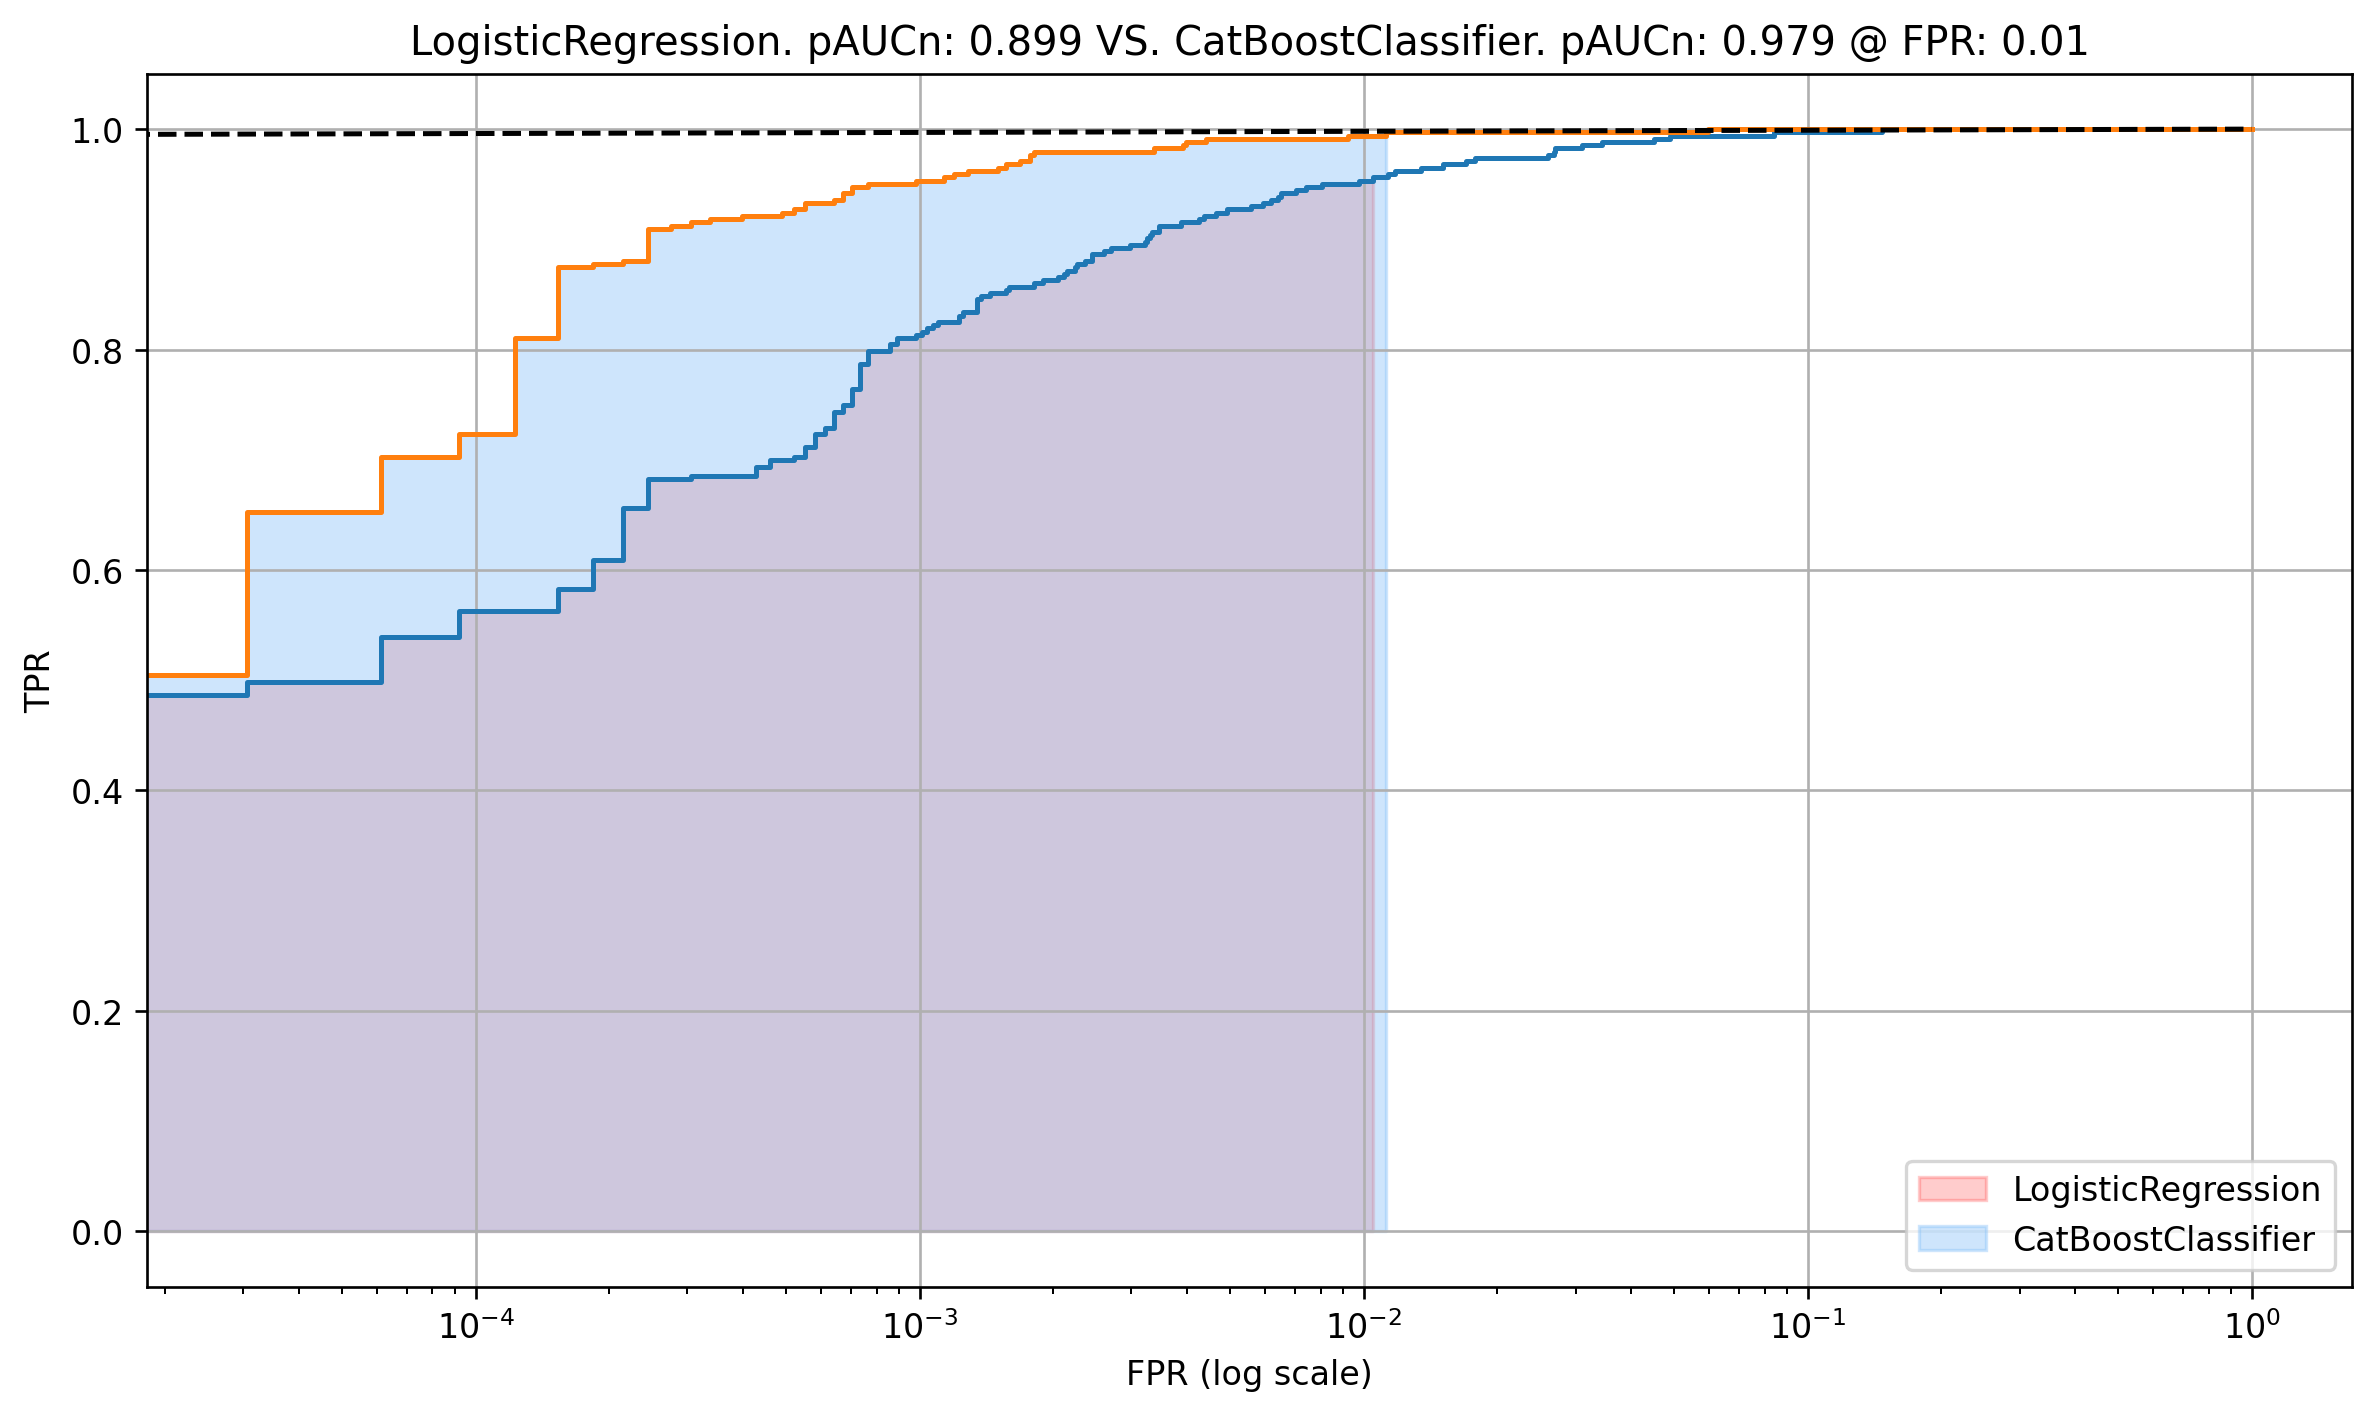

In [299]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(fpr_1, tpr_1)#, label=f'LogisticRegression')
ax.plot(fpr_2, tpr_2)#, label=f'CatBoostClassifier')
ax.plot([0,1], [0,1], linestyle='--', color='k')

ax.fill_between(fpr_1[:idx_1], tpr_1[:idx_1], color='r', label="LogisticRegression", alpha=0.2)
ax.fill_between(fpr_2[:idx_2], tpr_2[:idx_2], color='#85C0F9', label="CatBoostClassifier", alpha=0.4)
# ax.fill_between([0, fpr_cutoff], [1, 1], color='r', label="B", alpha=0.2)
ax.grid()
ax.legend(loc='lower right')
ax.set_xscale('log')
ax.set_xlabel('FPR (log scale)')
ax.set_ylabel('TPR')

ax.set_title(f'LogisticRegression. pAUCn: {pAUCn_1:0.3f} VS. CatBoostClassifier. pAUCn: {pAUCn_2:0.3f} @ FPR: {fpr_cutoff}')
plt.tight_layout()

# End